# Unsupervised Learning Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**Kobus Le Roux, Devon Woodman, Nhlanhla Mthembu, Koketso Maraba, Tebogo Khoza, Mxolisi Zulu, Cara Brits**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Movie Recommendation

__UPDATE ME__

### Problem Statement

__UPDATE ME__

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Conclusions</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


Let's start by turning off unnecessary warnings in the code, to improve the aesthetics of our notebook:

In [136]:
# Turning off unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

First, we include a list of uncommon packages that may need to be installed on your system. Uncomment and run the following if you need some of the packages listed:

In [137]:
# !pip install wordcloud
# !pip install comet_ml
# !pip install currencyconverter



Next, we import all necessary modules:

In [302]:
'''THIS IS JUST A TEMPLATE OF THE IMPORT CELL'''

# Libraries for Data Loading and Manipulation
import pandas as pd  # Pandas provides flexible data structures to manipulate structured data.
import numpy as np  # Numpy offers powerful data structures and tools for numerical computation.

# Text Processing Libraries
from nltk.corpus import stopwords  # Stopwords module provides a list of common words to be removed from the text.
from nltk import download as nltk_download  # For downloading nltk packages, here 'wordnet'.
import string  # Provides constants and classes for string manipulation.


# Data monitoring Libraries:
from comet_ml import Experiment  # Allows developers to track, compare, explain and optimize experiments and models.

# Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # Transforms text into feature vectors for machine learning.
from sklearn.metrics.pairwise import cosine_similarity # Used to find similarity matrix between features
from surprise import Dataset
from surprise import SVD 
from surprise import Reader
from surprise.model_selection import train_test_split 
from surprise import accuracy


# Data Visualization Libraries
import matplotlib.pyplot as plt  # Provides a way to visualize data (plotting, charts, etc.).
import seaborn as sns  # Provides a high-level interface for attractive, informative statistical graphics.
from sklearn.metrics import ConfusionMatrixDisplay # To visualize confusion matirces
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  # Wordcloud is used to visualize word frequency in the text.
sns.set_theme(style="whitegrid")  # Sets the style for seaborn plots.

# Utility Libraries
from currency_converter import CurrencyConverter


# Downloading necessary NLTK corpus
nltk_download('wordnet')

# Global Constants for reproducibility and consistency
COLAB_TRAIN_TEST_SPLIT_VAR = 0.8
RAND_STATE = 42
GENOME_RELEVANCE_THRESHOLD = 0.65 # Ignore genome tags below this threshold
USER_REVIEW_THRESHOLD = 10 # Only consider users with review counts larger than this number
MOVIE_REVIEW_THRESHOLD = 5000 # Only consider movies with more reviews than this number
CONTENT_VEC_MIN_WORD_TO_REMOVE = 1 # Remove words that occurs less that this value in dataset 


# Flags for notebook Execution
COMET_FLAG = False # To gauge wether to commit experiments to Comet ML


# Comet variables for logging experiments
COMET_API_KEY = "###########"
COMET_PROJECT_NAME = "########"
COMET_WORKSPACE = "#########"



<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The dataset available for this task comprises of millions of 5-star ratings provided by users of the online movie recommendation service, MovieLens. The MovieLens dataset has been extensively utilized by both industry and academic researchers to enhance the effectiveness of recommender systems that rely on explicit feedback. For this specific recommender model, we will be utilizing a modified edition of the MovieLens dataset that includes supplementary data and has been resampled. This modification aims to enrich the dataset and enable a more equitable assessment of the predictions made.

Since this dataset is extremely large, it will not be included in the GitHub repository along with this notebook, but can be downloaded from [here](https://www.kaggle.com/competitions/edsa-movie-recommendation-predict/data). The dataset consists of 8 files, each of which will be described below:

First up is the `genome_scores.csv` and `genome_tags.csv` files. The tag genome represents the degree to which movies possess specific characteristics indicated by tags, such as being atmospheric, thought-provoking, or realistic, among others. This tag genome was generated through a machine learning algorithm that processed user-contributed content, including tags, ratings, and textual reviews. By analyzing this content, the algorithm determined the associations between tags and movie properties, providing a comprehensive understanding of the attributes expressed by different films.

The `genome_scores.csv` file contains a score mapping the strength between movies and tag-related properties in the following format:

```csv
movieId,tagId,relevance
```
Here:

* __movieID__ contains the  movie identification number for our data
* __tagID__ contains the unique identification number for each tag present within the dataset
* __relevance__ contains a score between $0$ and $1$ representing how strongly movies exhibit particular properties represented by tag in question




In [139]:
# Reading data from the genome_scores.csv file and displaying format of the dataframe:
genome_scores_df = pd.read_csv("genome_scores.csv")
genome_scores_df.head(10)

movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075
5        1      6    0.14675
6        1      7    0.06350
7        1      8    0.20375
8        1      9    0.20200
9        1     10    0.03075

The `genome_tags.csv` file provides the tag descriptions for the tag IDs in the genome file, in the following format:
```csv
tagId,tag
```

Here:

* __tagID__ contains the unique identification number for each tag present within the dataset
* __tag__ contains the text description of the tag in question

In [140]:
# Reading data from the genome_tags.csv file and displaying format of the dataframe:
genome_tags_df = pd.read_csv("genome_tags.csv")
genome_tags_df.head(10)

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
5      6         1950s
6      7         1960s
7      8         1970s
8      9         1980s
9     10  19th century

Next up is the `imdb_data.csv` file, which contains additional movie metedata scraped from IMDB in the following format:
```csv
movieId, title_cast, director, runtime, budget, plot_keywords
```
Here:
* __movieID__ contains the  movie identification number for our data
* __title_cast__ contains the actors cast within the move, seperated by *|*
* __director__ contains the name of the movie director
* __runtime__ contains the movie runtime in minutes
* __budget__ contains the movie budget in USD ($)
* __plot_keywords__ containd keywords describing the plot, seperated by *|*
  

In [141]:
# Reading data from the imdb_data.csv file and displaying format of the dataframe:
imdb_data_df = pd.read_csv("imdb_data.csv")
imdb_data_df.head(10)

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   
5        6  Al Pacino|Robert De Niro|Val Kilmer|Jon Voight...   
6        7  Harrison Ford|Julia Ormond|Greg Kinnear|Nancy ...   
7        8  Jonathan Taylor Thomas|Brad Renfro|Eric Schwei...   
8        9  Jean-Claude Van Damme|Powers Boothe|Raymond J....   
9       10  Pierce Brosnan|Sean Bean|Izabella Scorupco|Fam...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   
5         Michael Mann    170.0  $60,000,000   
6     Samuel A. Taylor    127.0  $58,000,000   
7           Mark Twain     97.0          NaN   
8  Karen Elise Baldwin    111.0  $35,000,000   
9          Ian Fleming    130.0  $60,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion  
5  gun battle|organized crime|honor|criminal inve...  
6   character name as title|chauffeur|estate|playboy  
7  rescue from drowning|near drowning|character n...  
8     hockey|death in title|two word title|terrorist  
9  official james bond series|james bond characte...

We also have the `links.csv` file, which contain identifiers that can be used to link to other sources of movie data from different sources. It is in the format

```csv
movieId,imdbId,tmdbId
```

Here:
* __movieID__ contains the identifier used by [*MovieLens*](https://movielens.org)
* __imdbID__ contains the identifier used by [*IMBD*](http://www.imdb.com)
* __tmdb__ contains the identifier used by [*The Movie Data Base*](https://www.themoviedb.org)

In [142]:
# Reading data from the links.csv file and displaying format of the dataframe:
links_df = pd.read_csv("links.csv")
links_df.head(10)

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
5        6  113277    949.0
6        7  114319  11860.0
7        8  112302  45325.0
8        9  114576   9091.0
9       10  113189    710.0

The `movies.csv` file contains movie information in the following format:

```csv
movieId,title,genres
```

Here:
* __movieID__ contains the unique movie ID number
* __title__ contains the movie title and the year of release in parenthesis (might contain some errors)
* __genres__ contains a pipe separated list of applicable genres for the movie

The list of available genres are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

In [143]:
# Reading data from the movies.csv file and displaying format of the dataframe:
movies_df = pd.read_csv("movies.csv")
movies_df.head(10)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
5                        Action|Crime|Thriller  
6                               Comedy|Romance  
7                           Adventure|Children  
8                                       Action  
9                    Action|Adventure|Thriller

We also have access to the `tags.csv` file. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

```csv
userId,movieId,tag,timestamp
```
The lines within this file are ordered first by userId, then, within user, by movieId. Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Here:
* __userID__ contains the specific identification number for each user
* __movieID__ contains the unique identification number for each movie
* __tag__ contains the user generated tag for the movie
* __timestamp__ represents seconds since midnight Coordinated Universal Time (UTC) of *January 1, 1970*

In [144]:
# Reading data from the tags.csv file and displaying format of the dataframe:
tags_df = pd.read_csv("tags.csv")
tags_df.head(10)

userId  movieId                      tag   timestamp
0       3      260                  classic  1439472355
1       3      260                   sci-fi  1439472256
2       4     1732              dark comedy  1573943598
3       4     1732           great dialogue  1573943604
4       4     7569         so bad it's good  1573943455
5       4    44665     unreliable narrators  1573943619
6       4   115569                    tense  1573943077
7       4   115713  artificial intelligence  1573942979
8       4   115713            philosophical  1573943033
9       4   115713                    tense  1573943042

Lastly, we have our `test.csv` and `train.csv` datafiles. These datafiles represents the respective testing and training splits of the dataset. 

The file `train.csv` contains user and movie ID's along with the associated rating data in the format:
```csv
userId,movieId,rating,timestamp
```

Here:
* __userID__ represents the unique number identifying each user
* __movieID__ represents the unique number identifying each user
* __rating__ represents a score out of 5 given to each movie by each user. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars)
* __timestamp__ represents the seconds since midnight Coordinated Universal Time (UTC) of *January 1, 1970*

In [145]:
# Reading data from the train.csv file and displaying format of the dataframe:
train_df = pd.read_csv("train.csv")
train_df.head(10)

userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837
5  120949    81768     3.0  1289595242
6   19630    62049     4.0  1246729817
7   21066     2282     1.0   945785907
8  117563   120474     4.0  1515108225
9  144018     1997     5.0  1109967647

The `test.csv` file is similar to that of `train.csv`, but the rating data and timestamp is omitted. Therefore it has the structure
```csv
userId,movieId
```

These columns represent the same variables described for `train.csv` above

In [146]:
# Reading data from the test.csv file and displaying format of the dataframe:
test_df = pd.read_csv("test.csv")
test_df.head(10)

userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318
5       1     8405
6       1     8786
7       2      150
8       2      356
9       2      497

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Before we can start building accurate and cohesive models, it is of paramount importance to truly understand the data. This section is dedicated to our Exploratory Data Analysis (EDA). This is a crucial step in data analysis that aims to understand the dataset's structure, patterns, and underlying relationships. It involves examining and visualizing the data, identifying missing values, outliers, and anomalies, as well as performing statistical calculations and descriptive statistics. EDA helps uncover insights, gain familiarity with the data, and inform subsequent steps in the analysis process, such as feature selection, data preprocessing, and modeling. It aids in making informed decisions, formulating hypotheses, and guiding further exploration or modeling techniques to extract meaningful insights from the data.

### 3.1 General structure of the data

We start off by investigating the general structure of our raw data. For each datafile, we investigate the amount of entries, the amount of missing values, and the amount of duplicate entries

We start with the `genome_scores.csv` data:

In [147]:
# Show structure of genome scores data
genome_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


We see that this datafile contains an enormous amount $(>15 million)$ entries! This is to be expected since this data maps each movie in the database to each genome tag present within the database. As such, we may consider transforming this data so that only the relevant tags for each movie remains

Next, we investigate if this datafile contains any missing values:


In [148]:
# Count missing entries for each column
genome_scores_df.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

Luckily for us, no missing entries are present within this datafile.

Lastly, we investigate if the datafile contains duplicate entries to remove:

In [149]:
# Investigate duplicate entries
duplicates = genome_scores_df[genome_scores_df.duplicated(subset=['tagId', 'movieId', 'relevance'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


We also found no repeating entries within this file. 

We repeat the same process above for the `genome_tags.csv` file:

In [150]:
# Investigate data structure
genome_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


We see that there is a total of $1128$ genome tags present within our dataset. We also find that the *tag* data is of type object, and might need to be converted to string.

Wel also investigate if there is duplicate tags:

In [151]:
# Investigate repeating entries
duplicates = genome_tags_df[genome_tags_df.duplicated(subset=[ 'tag'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


We find all tags in this datafile to be unique. 

As before, we also consider if the datafile contains any missing values: 

In [152]:
# Investigate missing values
genome_tags_df.isnull().sum()

tagId    0
tag      0
dtype: int64

All the data seems to be present. 

Next, we consider the `imdb_data.csv` file. We start by investigating the structure of the data:

In [153]:
# Investigate data structure
imdb_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


We see that this particular file contains information about $27 278$ movies, including their cast, director, runtime, budget and plot points. We also note that all of our text data is pf type object, and might need to be converted to strings. Let's investigate if any of the features contains missing values

In [154]:
# Investigate missing values
imdb_data_df.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

We see that there is missing values present in multiple features within this datafile. Since trying to impute these values form median or mean statistics would be nonsensical, we should consider obtaining extra datasets to fill in the gaps within our data. 

Considering that this datafile is the first to present some problems with the data contained within, let's also consider if the data present within the file is credible.

In [155]:
# Combining movie info from imdb_data.csv and movies.csv
df_movie_combo = pd.merge(imdb_data_df, movies_df, on="movieId", how='left')

# Showing specific movie for illustration
df_movie_combo[df_movie_combo['movieId']==10]

movieId                                         title_cast     director  \
9       10  Pierce Brosnan|Sean Bean|Izabella Scorupco|Fam...  Ian Fleming   

   runtime       budget                                      plot_keywords  \
9    130.0  $60,000,000  official james bond series|james bond characte...   

              title                     genres  
9  GoldenEye (1995)  Action|Adventure|Thriller

We see that, according to the data contained within `imdb_data.csv`, the director for the file **GoldenEye (1995)** is considered to be *Ian Flemming*. However, a quick google search reveals the following:

<br></br>

<div align="center" >
<img src="./Resources/goldeneye.png"
     alt="Goldeneye (1995)"
     style="float: center; padding-bottom=0.5em"
     width=300px/>
<div align="center" >
GoldenEye movie metadata 
</div>





We see that our data wrongly confuses the director of the movie *(Martin Campbell)*, with the author of the book that the movie is based on. This gives even further cause to obtain some extra supplementary data regarding the movies we wish to consider.

Lastly, let's consider if there is any duplicate movies present in the `imdb_data.csv` file

In [156]:
# Investigating duplicate entries
duplicates = imdb_data_df[imdb_data_df.duplicated(subset=['movieId', 'title_cast', 'director', 'runtime', 'budget', 'plot_keywords'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


All movies seems to be unique in the data.

Shifting our gaze to the `links.csv` file:

In [157]:
# Investigating data structure
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


We see that this datafile contains linking ID numbers for $62423$ movies. These links will be used when obtaining additional data to supplement our movie data as discussed in the consideration of the `imdb_data.csv` above. Let's consider if there is any missing ID numbers:

In [158]:
# Investigate missing values
links_df.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

We see that we don't have the *tmbID's* for $107$ movies within our data, but we do have all of the *imdbID's*. Therefore, we will use the IMDB database to supplement our movie metadata

Finally, searching for duplicate links:

In [159]:
# Investigate duplicate entries
duplicates = links_df[links_df.duplicated(subset=['imdbId', 'movieId', 'tmdbId'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


We see that all of the ID's present in this datafile is unique.

Next, we will take a look at the `movies.csv` datafile

In [160]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


We find that this file provides the title and the genre for a total of $62423$ movies. This title and genre is stored as object types, and might need to be converted to string data types

In [161]:
# Investigate missing entries:
movies_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

We further see that no titles or genres are missing from this datafile. Finally, we should consider if this datafile contains any repeating entries:

In [162]:
# Investigate duplicate entries
duplicates = movies_df[movies_df.duplicated(subset=['title', 'movieId', 'genres'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


All of the entries in the `movies.csv` file seems to be unique

Next, we will take a closer look at the `tags.csv` file.

In [163]:
# Investigate data structure
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


This datafile contains custom tags given to each movie by viewers. We see that we have more than $ 1 million $ data entries mapping tags to movies in this datafile, which is a lot. Therefore, we should only consider the custom tags, and group them by movies so that we have a lot fewer entries

In [164]:
# Investigate missing values
tags_df.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Only 16 entries of the `~1million` entries contain missing tag details, and should be removed from consideration.

Considering if there exist duplicate entries:

In [165]:
# Investigate non-unique entries
duplicates = tags_df[tags_df.duplicated(subset=['userId', 'movieId', 'tag', 'timestamp'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


We find that all of the entries are unique.

Let us shift our focus to the `train.csv` file. This file contains all the ratings that will be used to train our models

In [166]:
# Investigate data structure
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


We see that we are working with ~ 10 million movie ratings within this datafile, which is an enormous amount. Let's consider if there is any missing ratings:

In [167]:
# Investigate missing values
train_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

We see that no missing ratings are present within the data. 

In [168]:
# Investigate duplicate entries
duplicates = train_df[train_df.duplicated(subset=['userId', 'movieId', 'rating', 'timestamp'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


Importantly, we find that no duplicate ratings are present within the data.

Let's dive a bit deeper to see if we can find the amount of users and movies within this dataset:


In [169]:
# Count unique userId's
user_amount = len(train_df.groupby("userId").mean())

# Count unique movieId's 
movie_amount = len(train_df.groupby("movieId").mean())

print("This data contains", user_amount, "unique users rating a total of", movie_amount, "unique movies")

This data contains 162541 unique users rating a total of 48213 unique movies


We see that we have over 160 000 users giving ratings on almost 50 000 movies! We need to consider carefully on how we are going to select the subset of training data that will be used to fit our models


Doing the same for the `test.csv` dataset:

In [170]:
# Structure of data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


We see that the testing dataset contains approximately 5 million entries. These entries will be used for testing our model performance when submitting our predictions to the Kaggle competition

In [171]:
# Investigate missing values
test_df.isnull().sum()

userId     0
movieId    0
dtype: int64

As expected, there is no missing values in the test dataset

In [172]:
duplicates = train_df[train_df.duplicated(subset=['userId', 'movieId'], keep=False)]
if duplicates.empty:
    print("No repeating entries found.")
else:
    print("Repeating entries found:")
    print(duplicates)

No repeating entries found.


There is also no duplicate entries in this dataset.

### 3.2 Ratings

Let's take a closer look into the rating data that will be used to train our models. 

#### 3.2.1 Rating Distribution

Let us see how our movie ratings are distributed over our entire userbase:


In [173]:
# Statistical breakdown of ratings:
train_df["rating"].describe().round(2)

count    10000038.00
mean            3.53
std             1.06
min             0.50
25%             3.00
50%             3.50
75%             4.00
max             5.00
Name: rating, dtype: float64

We would expect the average rating to be around 2.5 stars, since that is the midpoint of our rating range. Instead we find that the rating distribution is not what we expected, and the average rating is closer to 3.5 stars. It appears that users tend to be generous with their reviews, and give higher ratings on average than lower ones. This is something we should account for when training the model. Standardizing the rating feature might be a wise consideration. 

Let's investigate the ratings further by plotting their distribution:

Text(0.5, 0, 'Stars')

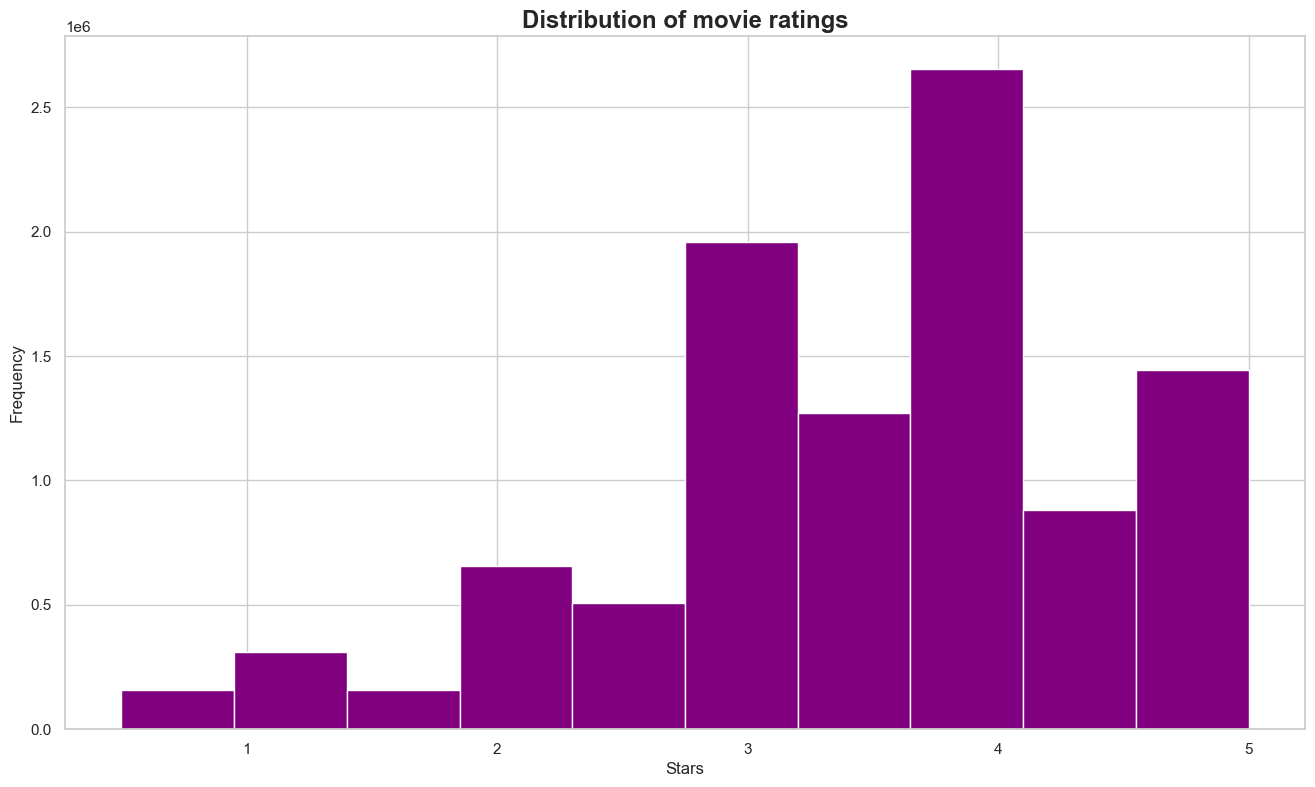

In [174]:
# Plot rating distribution
graph = train_df["rating"].plot(kind="hist", figsize=(16,9), legend=False, color = "Purple")
graph.set_title("Distribution of movie ratings", fontsize="x-large", fontweight='bold')
graph.set_xlabel("Stars")


We see that the vast majority of our rating data lies between 3 and 5 stars. The fact that the rating distribution is left-skewed corroborates the notion that people tend to give higher ratings on average to movies.  

#### 3.2.2 User Activity:

Something else to consider is how active the average user is when it comes to providing ratings for the movies that they watch. Let's create a new dataset containing the amount of reviews each user has provided:

In [175]:
# Create review counts for users
user_review_counts_df = pd.DataFrame(train_df["userId"].value_counts(ascending=False))
user_review_counts_df.head()

count
userId       
72315   12952
80974    3680
137293   3588
33844    3208
20055    3050

We see that user $72351$ has rated the most number of movies, totalling almost $13000$! One wonders if he has time to do anything else...

Let's investigate the distribution of user review counts:

In [176]:
# Investigate user review trends
user_review_counts_df["count"].describe().round(2)


count    162541.00
mean         61.52
std         107.41
min           1.00
25%          14.00
50%          28.00
75%          65.00
max       12952.00
Name: count, dtype: float64

We see that the average amount of reviews per user is around ~ 61. We can investigate the distribution in the review frequencies visually:

(0.0, 500.0)

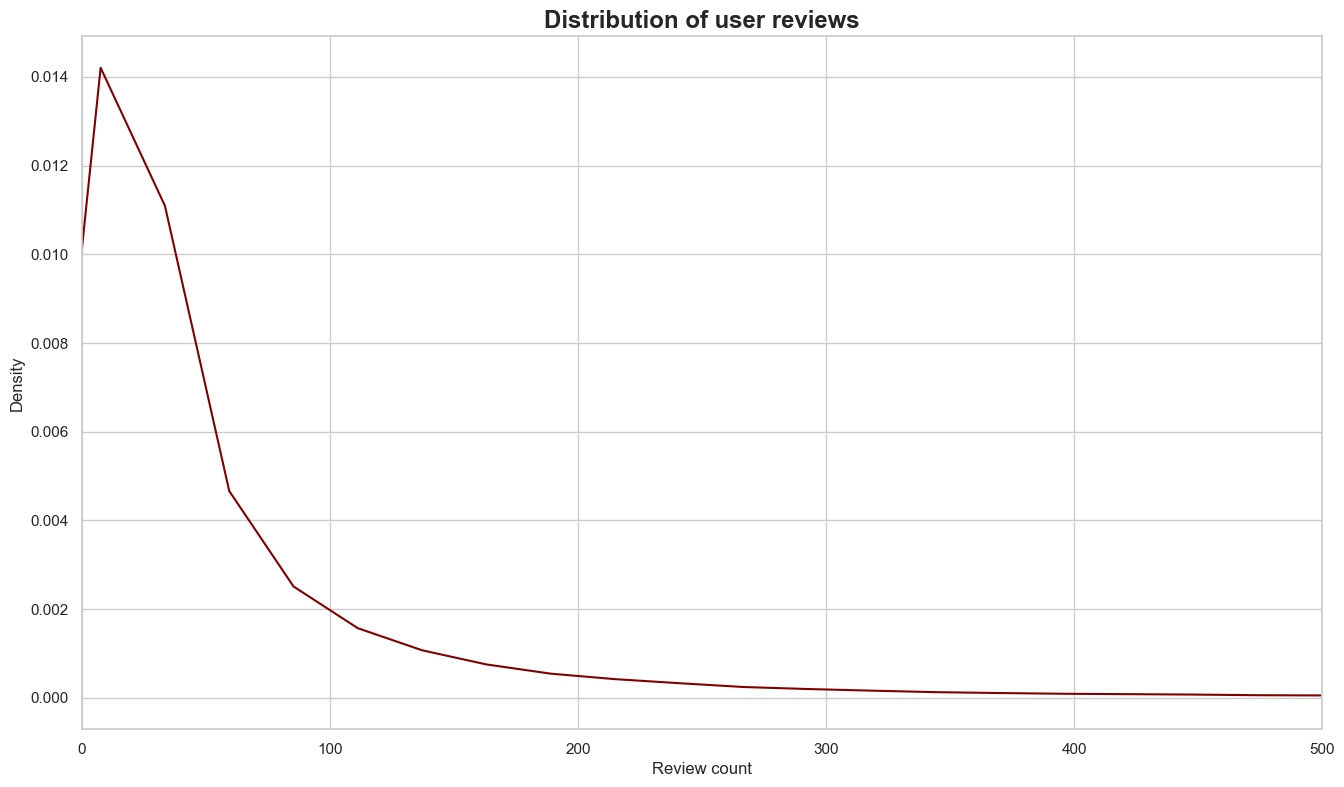

In [177]:
# Plot rating distribution
graph = user_review_counts_df.plot.density(figsize = (16,9),legend=False, color="maroon")
graph.set_title("Distribution of user reviews", fontsize="x-large", fontweight='bold')
graph.set_xlabel("Review count")
graph.set_xlim(0, 500)


We see that even though we have users contributing thousands of movie reviews, the vast majority of viewers submit a lot less reviews. Let's investigate the most occurring review frequency:

In [178]:
print("The most often occuring review amount is" , user_review_counts_df["count"].mode()[0], "reviews")

The most often occuring review amount is 10 reviews


Since we are dealing with a very large dataset, we should consider training our models on users that have rated more than 10 movies. This eliminates a substantial portion of the data while simultaneously prioritizing reviews from users who are not only more established on the platform, but also have enough reviews to form a large enough sample size for more robust statistical analysis. By focusing on users who have rated more than 10 movies, we can ensure that we have a sufficient sample size to draw meaningful conclusions. A larger sample size provides more reliable statistics, reducing the potential impact of outliers or random variations. It allows for more accurate estimation of user preferences and patterns, enabling better generalization and prediction performance of the trained models.

### 3.3 Most and least popular:

Next, let's consider some of the most and least popular movie features within the dataset: 

#### 3.3.1 Movies

We begin by ranking the movies in our dataset by their ratings. Let's first consider which movies obtain the most ratings, and can therefore be considered to be popular:

In [179]:
# Creating a copy of rating data
eda_ratings_df = train_df

# Getting amount of ratings for each movie
movie_rating_counts = pd.DataFrame(eda_ratings_df["movieId"].value_counts())
movie_rating_counts.rename(columns={"count":"review_count"}, inplace=True)

# Creating new feature containing movie rating counts 
eda_ratings_df = pd.merge(eda_ratings_df, movie_rating_counts, on="movieId", how="left")



# Grouping by movies to obtain average ratings for movies
df_ratings =  eda_ratings_df.groupby("movieId").mean()
df_ratings.drop(["userId", "timestamp"], axis=1, inplace=True)

# Sorting by rating count:
df_ratings.sort_values("review_count", inplace=True, ascending=False)

# Joining the movie title to the data
movie_titles = movies_df.drop("genres", axis=1)
df_ratings = pd.merge(df_ratings, movie_titles, on="movieId", how="left")

df_ratings.head(20)

movieId    rating  review_count  \
0       318  4.417624       32831.0   
1       356  4.047216       32383.0   
2       296  4.195097       31697.0   
3       593  4.144172       29444.0   
4      2571  4.154253       29014.0   
5       260  4.111811       27560.0   
6       480  3.684634       25518.0   
7       527  4.247625       24004.0   
8       110  3.994119       23722.0   
9      2959  4.227906       23536.0   
10      589  3.951419       23075.0   
11        1  3.889971       23062.0   
12     1196  4.146236       22956.0   
13     4993  4.087257       22216.0   
14       50  4.278073       22032.0   
15     1198  4.120530       21982.0   
16     1210  3.994112       21909.0   
17     2858  4.105595       21644.0   
18      858  4.311355       20960.0   
19     7153  4.086074       20430.0   

                                                title  
0                    Shawshank Redemption, The (1994)  
1                                 Forrest Gump (1994)  
2                                 Pulp Fiction (1994)  
3                    Silence of the Lambs, The (1991)  
4                                  Matrix, The (1999)  
5           Star Wars: Episode IV - A New Hope (1977)  
6                                Jurassic Park (1993)  
7                             Schindler's List (1993)  
8                                   Braveheart (1995)  
9                                   Fight Club (1999)  
10                  Terminator 2: Judgment Day (1991)  
11                                   Toy Story (1995)  
12  Star Wars: Episode V - The Empire Strikes Back...  
13  Lord of the Rings: The Fellowship of the Ring,...  
14                         Usual Suspects, The (1995)  
15  Raiders of the Lost Ark (Indiana Jones and the...  
16  Star Wars: Episode VI - Return of the Jedi (1983)  
17                             American Beauty (1999)  
18                              Godfather, The (1972)  
19  Lord of the Rings: The Return of the King, The...

Shown above is a list of the top 25 most popular movies within the dataset by measure of review amounts. If we make the reasonable assumption that the amount of reviews a film obtains is correlated to the amount of views it receives, we can conclude that these are the most watched movies within our dataset. To help visualize the table above, let's plot each film to the amount of rating it received:

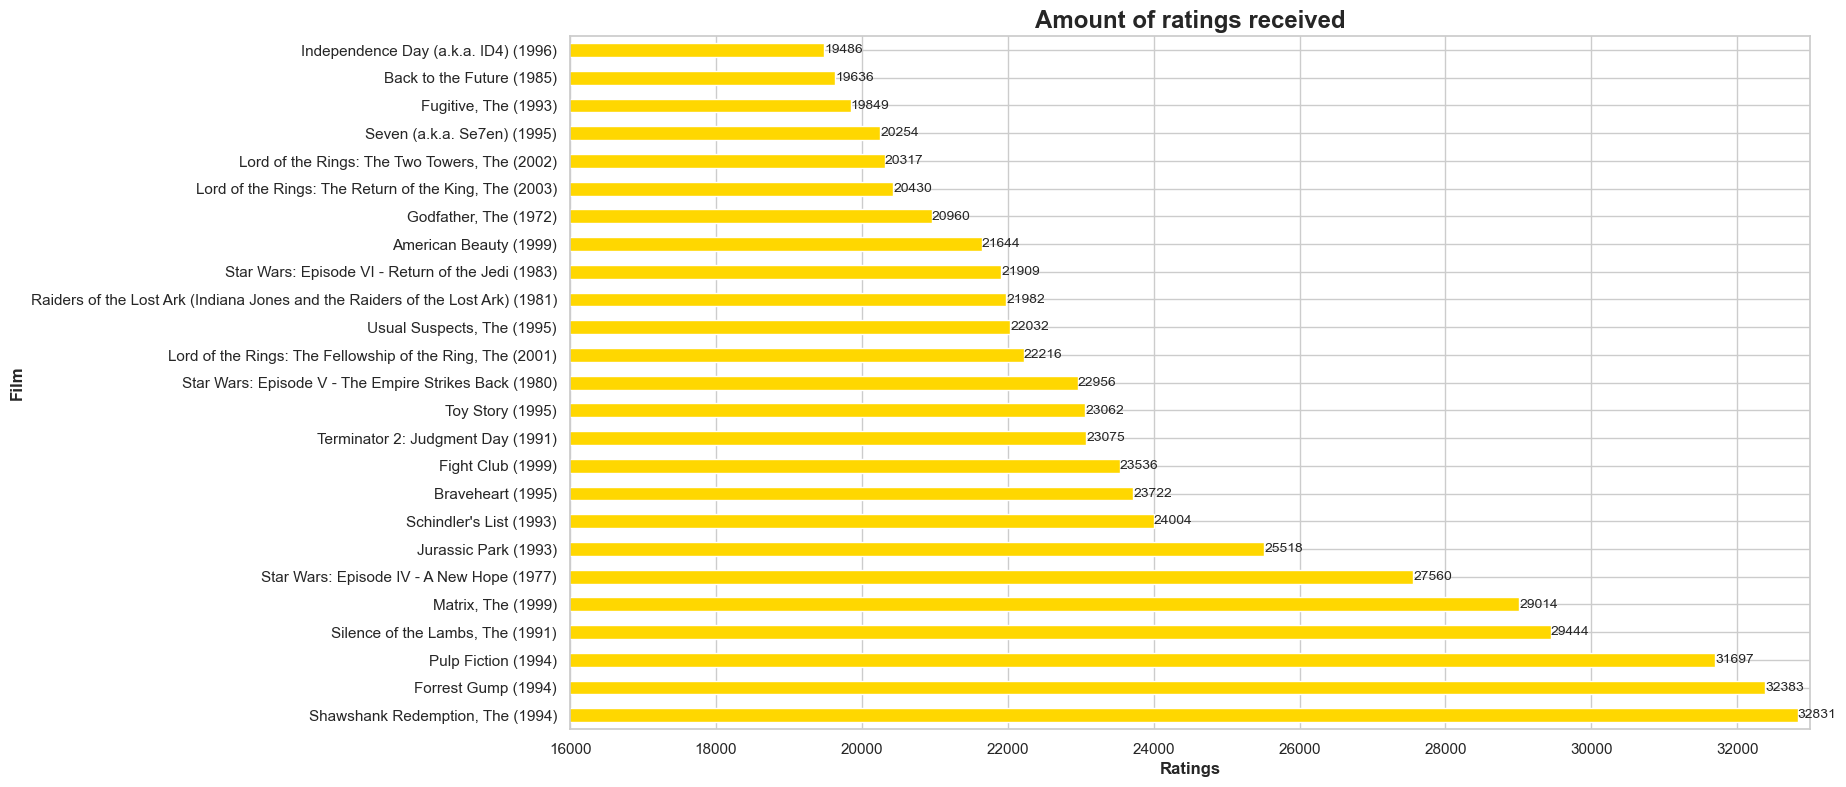

In [180]:
# Plotting the most reviewed movies'
graph = df_ratings.head(25).plot(x="title", y="review_count", kind='barh', xlim=(16000, 33000),  figsize=(16,9),  legend=False, color="gold")
graph.set_title("Amount of ratings received", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Ratings", fontweight='bold')
graph.set_ylabel("Film", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

We see that all __The Shawshank Redemption__ is the most popular movie in our data, followed closely by __Forrest Gump__. Considering the top 20 movies in our dataset, we see that most of them are classic movies from the *1990's*. Since these movies obtain a lot of ratings, and by extension views, we should consider recommending some of them to new users on the platform if we have little to no data on their preferences. We can refine this list even further by not only considering a movie's popularity in terms of rating count, but also the average rating it obtains. We consider movies with more than 10 000 reviews (to ensure high popularity), and order them by their average rating:

In [181]:
# Filter out movies with less than 10000 reviews
df_ratings_filtered = df_ratings[df_ratings["review_count"]>= 10000]

# Sort list by average rating
df_ratings_filtered.sort_values("rating", ascending=False, inplace=True)

df_ratings_filtered["rating"] = df_ratings_filtered["rating"].round(decimals=3)

df_ratings_filtered.head(20)

movieId  rating  review_count  \
0        318   4.418       32831.0   
18       858   4.311       20960.0   
14        50   4.278       22032.0   
65      1221   4.274       13525.0   
7        527   4.248       24004.0   
9       2959   4.228       23536.0   
55      1193   4.218       14403.0   
116      750   4.218       10673.0   
115      912   4.215       10735.0   
2        296   4.195       31697.0   
72      1213   4.177       13108.0   
37     58559   4.172       16600.0   
42     79132   4.162       15451.0   
4       2571   4.154       29014.0   
12      1196   4.146       22956.0   
39      4226   4.145       16536.0   
3        593   4.144       29444.0   
46      1136   4.140       15102.0   
83      2329   4.140       12504.0   
53       541   4.127       14619.0   

                                                 title  
0                     Shawshank Redemption, The (1994)  
18                               Godfather, The (1972)  
14                          Usual Suspects, The (1995)  
65                      Godfather: Part II, The (1974)  
7                              Schindler's List (1993)  
9                                    Fight Club (1999)  
55              One Flew Over the Cuckoo's Nest (1975)  
116  Dr. Strangelove or: How I Learned to Stop Worr...  
115                                  Casablanca (1942)  
2                                  Pulp Fiction (1994)  
72                                   Goodfellas (1990)  
37                             Dark Knight, The (2008)  
42                                    Inception (2010)  
4                                   Matrix, The (1999)  
12   Star Wars: Episode V - The Empire Strikes Back...  
39                                      Memento (2000)  
3                     Silence of the Lambs, The (1991)  
46              Monty Python and the Holy Grail (1975)  
83                           American History X (1998)  
53                                 Blade Runner (1982)

Again, we see that __The Shawshank Redemption__ takes the crown when considering this updated metric. Not only is it the most popular, but it is also the highest rated movie of all the popular movies. We visualize the list above again using a graph:

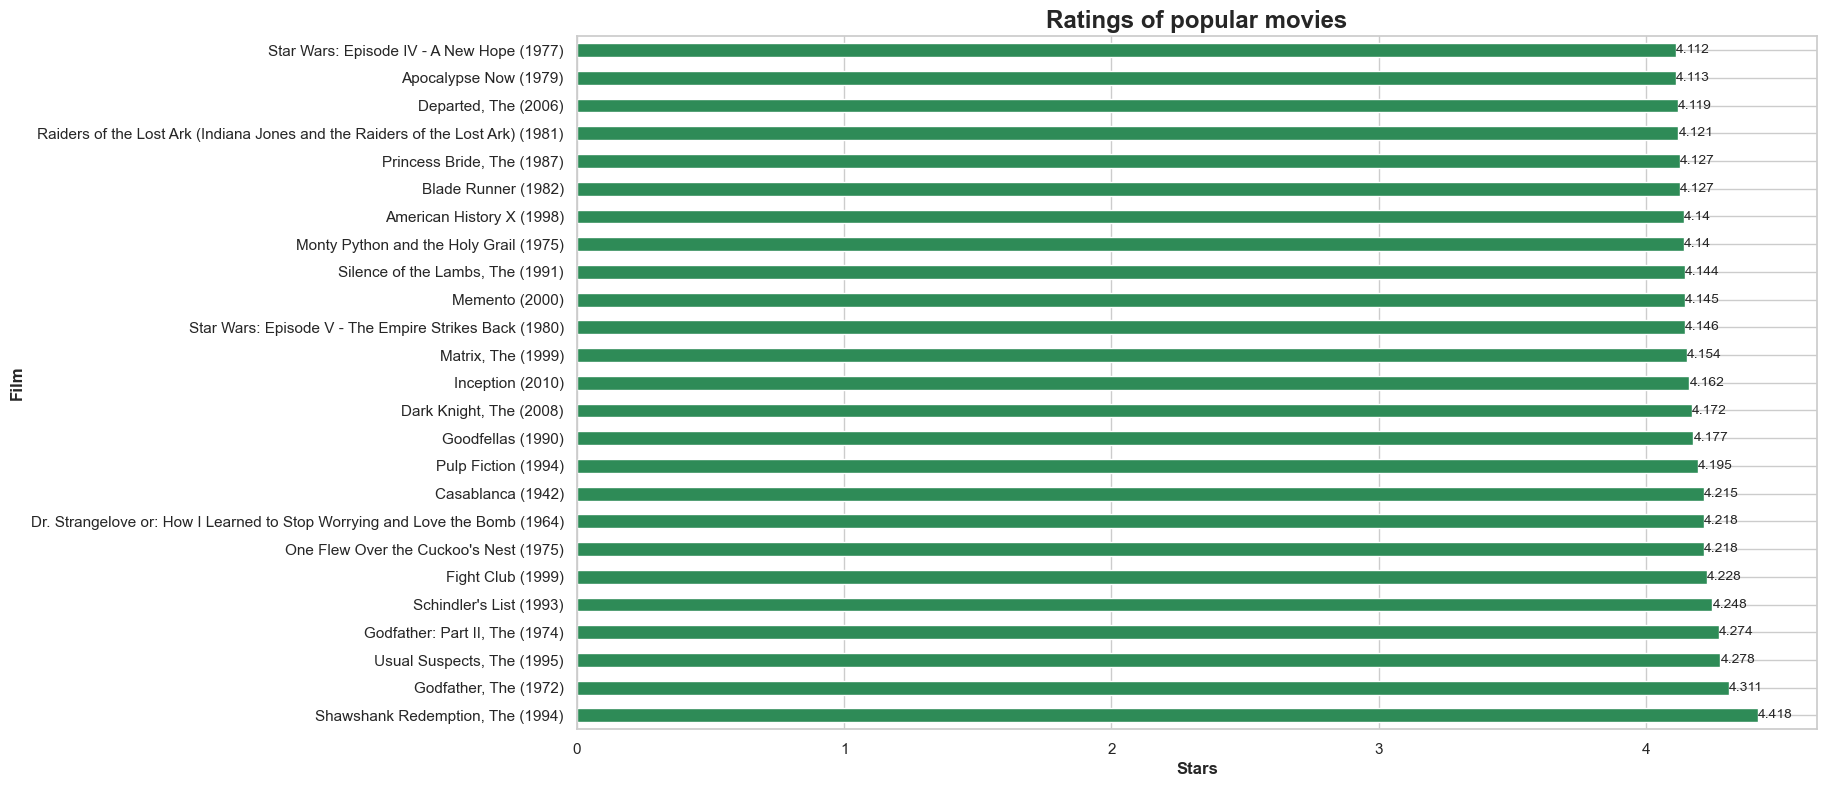

In [182]:
# Plotting the highest rated popular movies
graph = df_ratings_filtered.head(25).plot(x="title", y="rating", kind='barh',  figsize=(16,9),  legend=False, color="seagreen")
graph.set_title("Ratings of popular movies", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Stars", fontweight='bold')
graph.set_ylabel("Film", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

We have successfully identified 2 categories which could be recommended to new users. The first we will name *Popular Movies* and that will contain a list of the most rated movies on the platform. The second could be *Critically Acclaimed Movies*, which will feature the highest rated popular movies


We should also consider movies that are extremely unpopular, in an attempt to not only discard them form the model training process, but also to steer clear from incorporating them into the streaming site. First, let's investigate the distribution of movie ratings:

In [183]:
# Investigate movie rating distribution
df_ratings["review_count"].describe()

count    48213.000000
mean       207.413727
std       1092.768777
min          1.000000
25%          1.000000
50%          4.000000
75%         26.000000
max      32831.000000
Name: review_count, dtype: float64

We see that the the average amount of reviews per movie is about $207$. This number is inflated by the large number of reviews that the most popular movies receive. About 75% of all the movies in our database contains less than 26 reviews, and the median review count for each movie is only 4!! Let's investigate the distribution of review counts for all the movies in our database: 

(0.0, 1000.0)

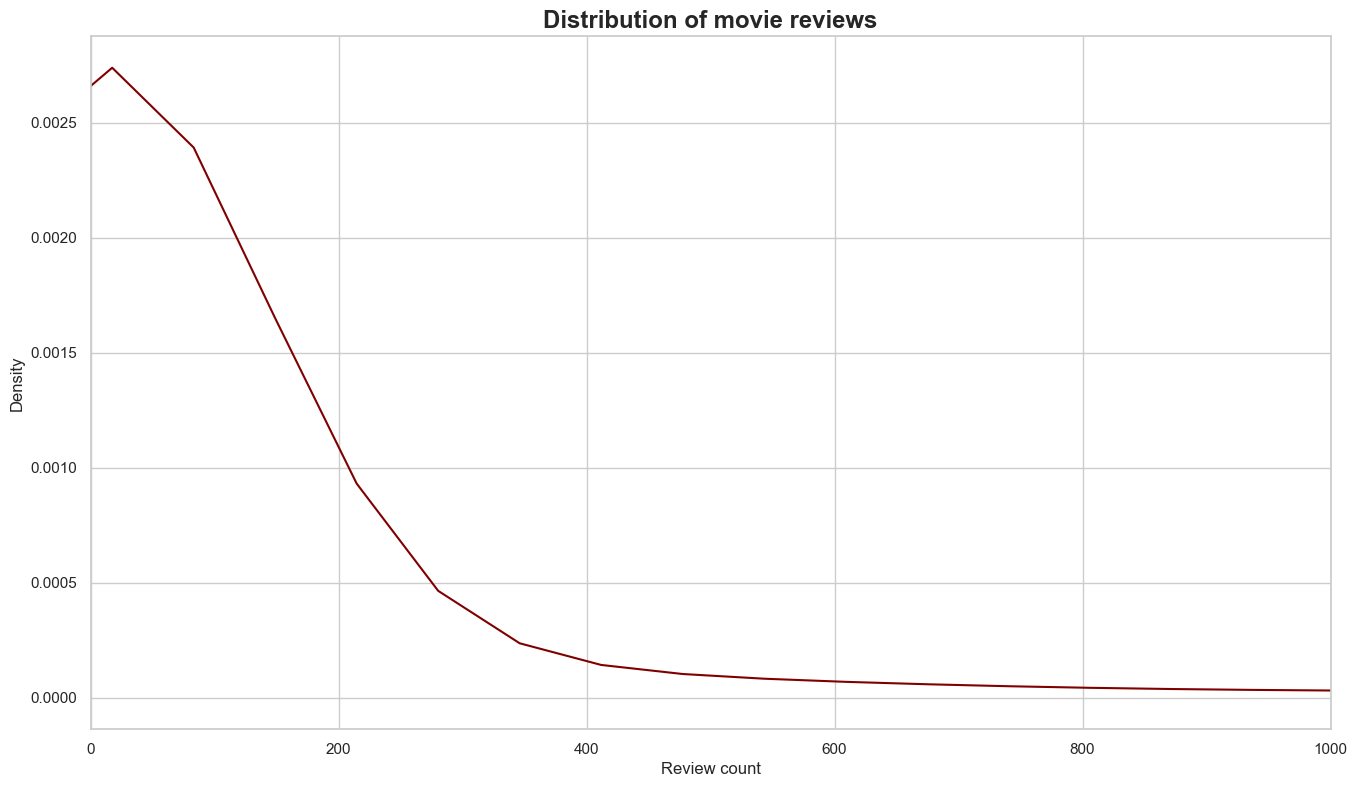

In [184]:
# Plot rating distribution for each movie
graph = df_ratings["review_count"].plot.density(figsize = (16,9),legend=False, color="maroon")
graph.set_title("Distribution of movie reviews", fontsize="x-large", fontweight='bold')
graph.set_xlabel("Review count")
graph.set_xlim(0, 1000)


From the graph above, it is extremely clear that the vast majority of movies within our data is extremely unpopular. This means that we efficiently reduce the size of the dataset when only considering movies that has more ratings than some threshold. For interest sake, let's consider how much the dataset is reduced when only considering movies that has more than 25 reviews:

In [185]:
# Considering rating threshold impact on dataset size
unmodified_length = len(df_ratings)
modified_length = len(df_ratings[df_ratings["review_count"]>=25])


print("Only considering movies with more than 25 ratings reduces the dataset from", unmodified_length, 'to', modified_length, 'entries')
print('(Only', round(modified_length/unmodified_length*100,2), '% of the dataset is considered)')

Only considering movies with more than 25 ratings reduces the dataset from 48213 to 12236 entries
(Only 25.38 % of the dataset is considered)


Since movies with few ratings doesn't provide us with a large enough sample size to accurately gauge their performance, we should consider removing them not only from consideration by the recommender models, but also from the streaming site in general, as they probably cost the company more in licensing fees than they will bring in with revenue. 

#### 3.3.2 Genres

Let us look at the genre distribution of movies contained within the dataset. To start off, let's investigate the proportion that each genre is present within the movies included in our data:

In [186]:
# Create copy of dataframe
df_genres_eda = movies_df

# Clean genre column
df_genres_eda['genres_split'] = df_genres_eda['genres'].str.replace('|', ' ') # Seperate genres with space
df_genres_eda['genres_split'] = df_genres_eda['genres_split'].replace('(no genres listed)', np.nan) 
df_genres_eda['genres_split'] = df_genres_eda['genres_split'].str.split(' ')

# Splitting genres for each movie
df_genres_eda = df_genres_eda.explode('genres_split')
df_genres_eda = df_genres_eda.drop(columns = ['genres'])
df_genres_eda.dropna(inplace = True)

# Counting each genre occurrence
df_grouped_genres_eda = df_genres_eda.groupby(by = 'genres_split').count()
df_grouped_genres_eda.rename(columns={"movieId": "Frequency"}, inplace=True)
df_grouped_genres_eda.drop("title", axis=1, inplace=True)
df_grouped_genres_eda.sort_values("Frequency", inplace=True, ascending=False)
df_grouped_genres_eda.head(20)



Frequency
genres_split           
Drama             25606
Comedy            16870
Thriller           8654
Romance            7719
Action             7348
Horror             5989
Documentary        5605
Crime              5319
Adventure          4145
Sci-Fi             3595
Children           2935
Animation          2929
Mystery            2925
Fantasy            2731
War                1874
Western            1399
Musical            1054
Film-Noir           353
IMAX                195

The table above gives us the frequency that each genre appears within our dataset. We see that the most occurring genre is that of *Drama*, followed by  *Comedy*. The least occurring genres are that of *Film-Noir* and *Imax* respectively

To show this visually, we plot a pie chart to represent the prevalence of each genre:

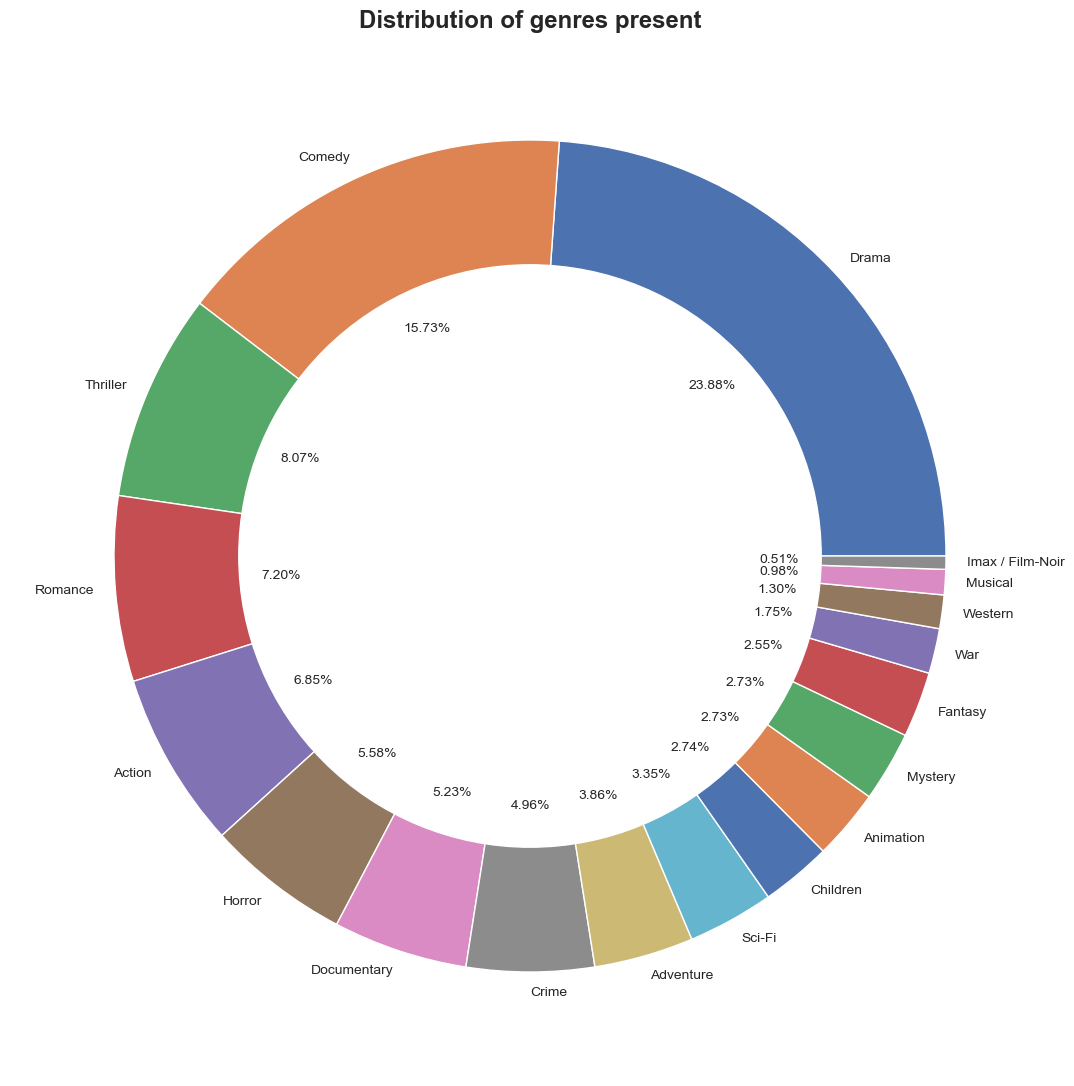

In [187]:
# Combining bottom 2 genres for aesthetic graph
combined_freq =  df_grouped_genres_eda['Frequency'].iloc[-2:].sum() # Combine the frequencies of the bottom two genres
df_grouped_genres_eda = df_grouped_genres_eda.iloc[:-2] # Remove bottom 2 genres
combined_row = pd.DataFrame({ 'Frequency': [combined_freq]}) # Add a new row for the combined genres
df_grouped_genres_eda = pd.concat([df_grouped_genres_eda, combined_row])
df_grouped_genres_eda.rename(index={0:'Imax / Film-Noir'}, inplace=True)


# Plotting the genre frequencies as donut chart:
graph = df_grouped_genres_eda.plot.pie(y='Frequency', legend=False, figsize=(16,16), autopct='%0.2f%%', labeldistance = 1.05, fontsize="small")
graph.set_title("Distribution of genres present", fontweight='bold', fontsize="x-large")
graph.set_ylabel("")
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

# Adjusting label positions
graph.set_aspect('equal')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75) 



We can also investigate the average rating obtained for each genre:

In [188]:
# Combining average rating with genre data 
df_genres_with_ratings = pd.merge(df_genres_eda, df_ratings.drop(["review_count", "title"], axis=1), on='movieId', how='left')

# Group data by average genre rating
df_genres_with_ratings.drop(["title", "movieId"], axis=1, inplace=True)
df_genres_average_ratings = df_genres_with_ratings.groupby("genres_split").mean()

# Sort genres on rating performance
df_genres_average_ratings.sort_values("rating", inplace=True, ascending=False)
df_genres_average_ratings["rating"] = df_genres_average_ratings["rating"].round(decimals=2)

df_genres_average_ratings.head(20)

rating
genres_split        
Documentary     3.40
Film-Noir       3.33
War             3.29
IMAX            3.25
Drama           3.21
Musical         3.21
Romance         3.19
Animation       3.15
Crime           3.12
Western         3.09
Mystery         3.08
Comedy          3.07
Fantasy         3.05
Children        3.05
Adventure       3.05
Thriller        2.97
Action          2.95
Sci-Fi          2.80
Horror          2.67

Here we see the average rating that each genre obtains. Our best performing genres are *Documentary*, *Film-Noir*, *War* and *Imax* while the *Sci-Fi* and *Horror* genres performs worst overall. To indicate this visually, we plot the respective rating performance of each genre for comparison:

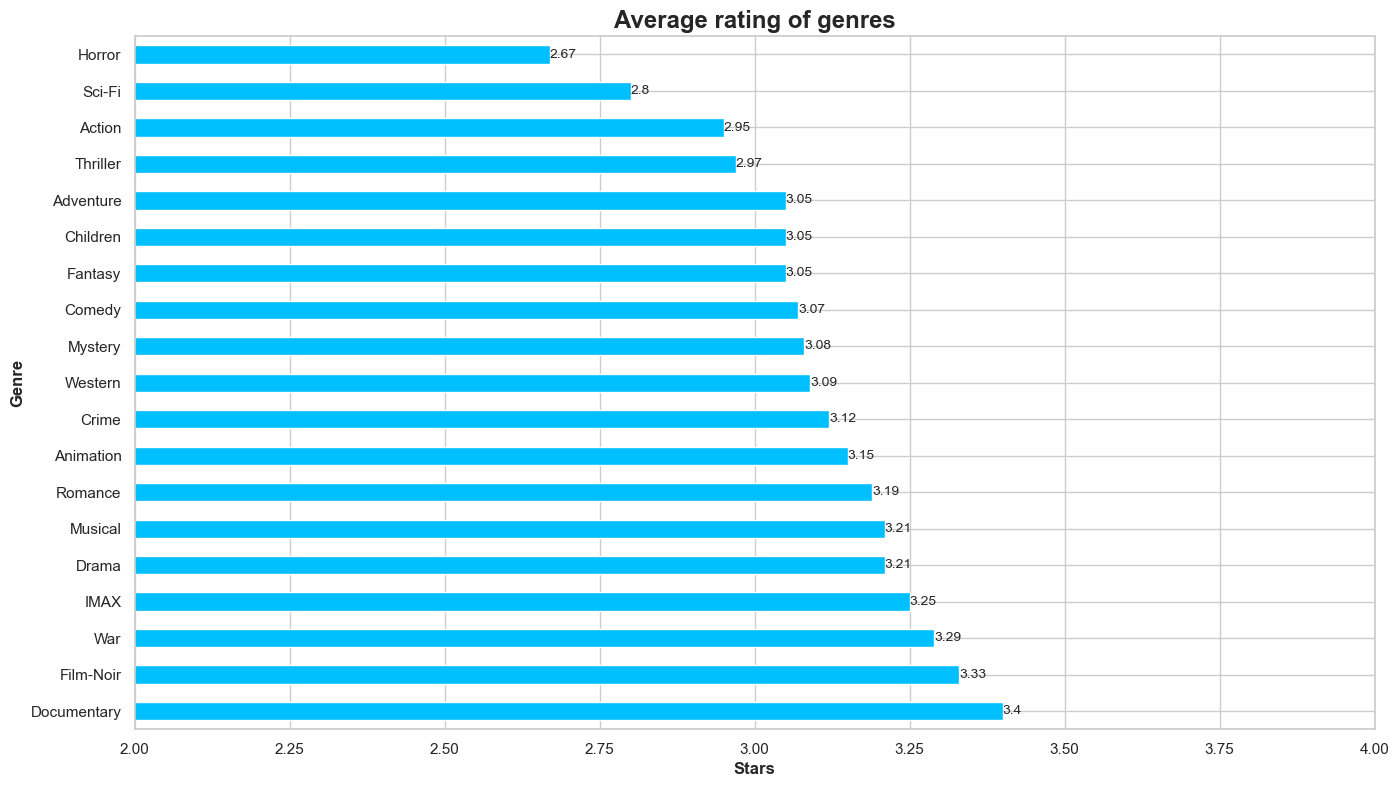

In [189]:
# Plotting genre average performance
graph = df_genres_average_ratings.plot( y="rating", kind='barh',  figsize=(16,9), xlim=(2,4), legend=False, color="deepskyblue")
graph.set_title("Average rating of genres", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Stars", fontweight='bold')
graph.set_ylabel("Genre", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

Since the average rating of *Horror* and *Sci_Fi* films performs the worst generally, it is recommended to slow the addition of these types of movies to the platform, and instead focus on adding movies with genres that perform better overall. 

Lastly, let's investigate the 5 top rated movies in each genre:

Text(0, 0.5, '')

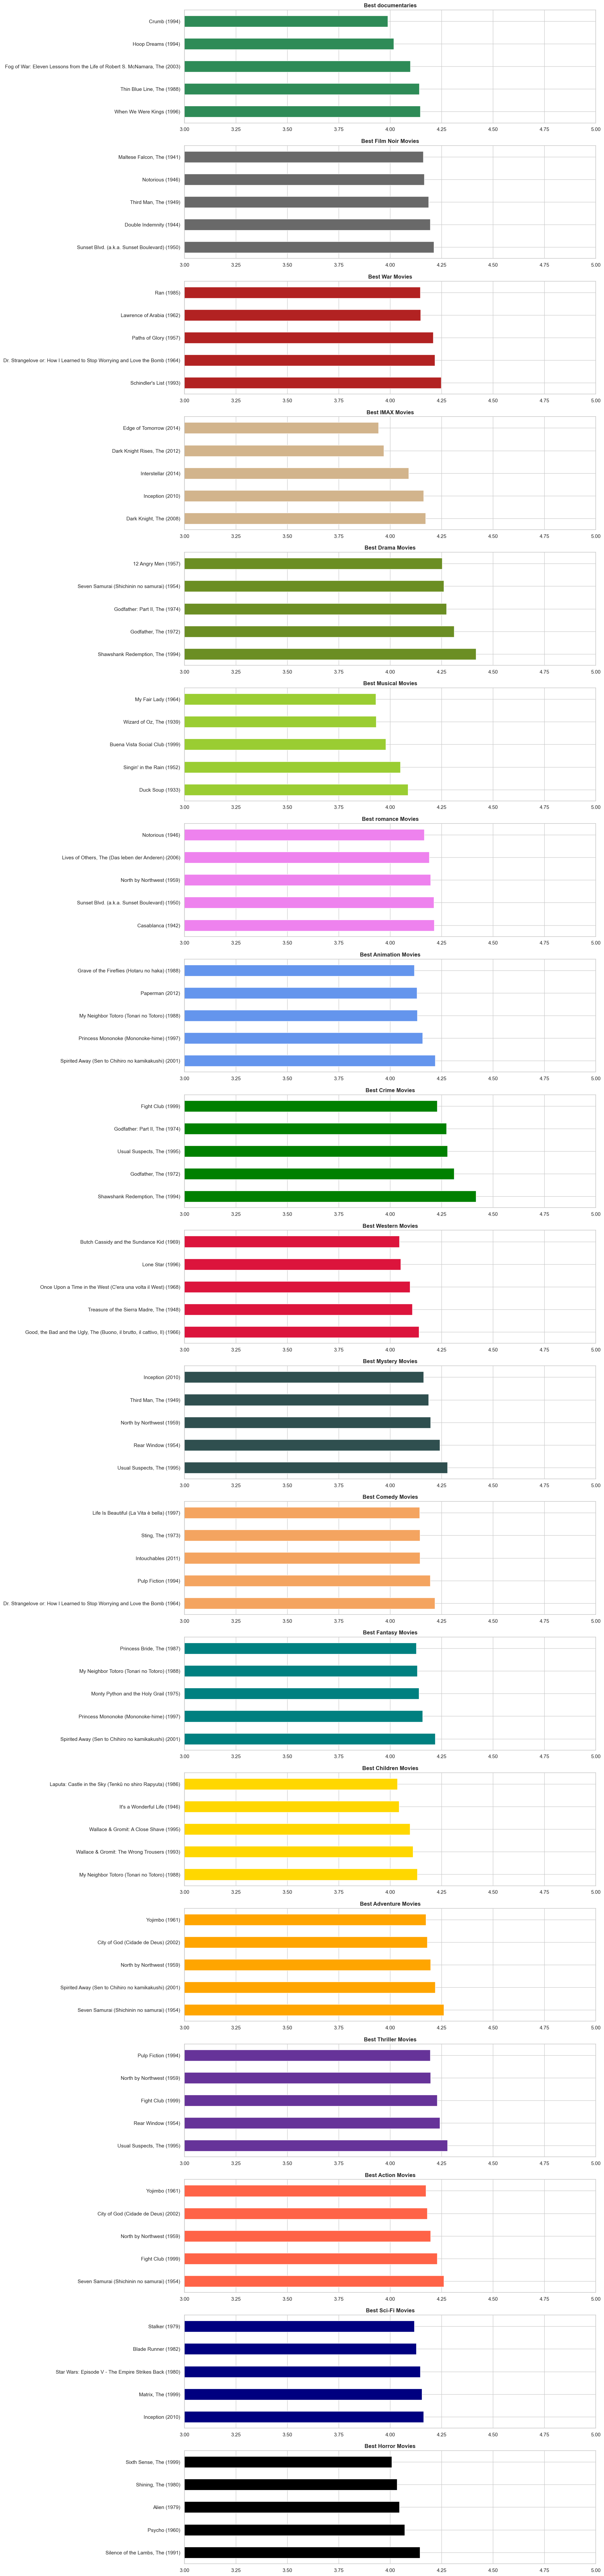

In [190]:
# Combining genre movie data with ratings
df_genres_to_split = pd.merge(df_genres_eda, df_ratings[["movieId", "rating", "review_count"]], on='movieId', how='left')

# Only consider movies with more than 5000 reviews
df_genres_to_split = df_genres_to_split[df_genres_to_split["review_count"]> 1000]

# Splitting df into genres:
df_documentary_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Documentary']
df_fnoir_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Film-Noir']
df_war_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'War']
df_imax_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'IMAX']
df_drama_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Drama']
df_musical_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Musical']
df_romance_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Romance']
df_animation_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Animation']
df_crime_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Crime']
df_western_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Western']
df_mystery_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Mystery']
df_comedy_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Comedy']
df_fantasy_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Fantasy']
df_children_movies = df_genres_to_split[df_genres_to_split["genres_split"] == 'Children']
df_adventure_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Adventure']
df_thriller_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Thriller']
df_action_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Action']
df_scifi_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Sci-Fi']
df_horror_movies  = df_genres_to_split[df_genres_to_split["genres_split"] == 'Horror']


# Sorting by ratings:
df_documentary_movies.sort_values("rating", ascending=False, inplace=True)
df_fnoir_movies.sort_values("rating", ascending=False, inplace=True)
df_war_movies.sort_values("rating", ascending=False, inplace=True)
df_imax_movies.sort_values("rating", ascending=False, inplace=True)
df_drama_movies.sort_values("rating", ascending=False, inplace=True)
df_musical_movies.sort_values("rating", ascending=False, inplace=True)
df_romance_movies.sort_values("rating", ascending=False, inplace=True)
df_animation_movies.sort_values("rating", ascending=False, inplace=True)
df_crime_movies.sort_values("rating", ascending=False, inplace=True)
df_western_movies.sort_values("rating", ascending=False, inplace=True)
df_mystery_movies.sort_values("rating", ascending=False, inplace=True)
df_comedy_movies.sort_values("rating", ascending=False, inplace=True)
df_fantasy_movies.sort_values("rating", ascending=False, inplace=True)
df_children_movies.sort_values("rating", ascending=False, inplace=True)
df_adventure_movies.sort_values("rating", ascending=False, inplace=True)
df_thriller_movies.sort_values("rating", ascending=False, inplace=True)
df_action_movies.sort_values("rating", ascending=False, inplace=True)
df_scifi_movies.sort_values("rating", ascending=False, inplace=True)
df_horror_movies.sort_values("rating", ascending=False, inplace=True)



# Plotting best rated movies for each genre
fig, axs = plt.subplots( 19, 1, figsize=(16,100))

# Documentaries
df_documentary_movies.head(5).plot(x="title", y="rating", kind='barh', color="seagreen", ax=axs[0], legend=False, xlim=(3,5))
axs[0].set_title("Best documentaries", fontweight='bold')
axs[0].set_xlabel("")
axs[0].set_ylabel("")

# Film Noir
df_fnoir_movies.head(5).plot(x="title", y="rating", kind='barh', color="dimgrey", ax=axs[1], legend=False, xlim=(3,5))
axs[1].set_title("Best Film Noir Movies", fontweight='bold')
axs[1].set_xlabel("")
axs[1].set_ylabel("")

# War
df_war_movies.head(5).plot(x="title", y="rating", kind='barh', color="firebrick", ax=axs[2], legend=False, xlim=(3,5))
axs[2].set_title("Best War Movies", fontweight='bold')
axs[2].set_xlabel("")
axs[2].set_ylabel("")

# Imax
df_imax_movies.head(5).plot(x="title", y="rating", kind='barh', color="tan", ax=axs[3], legend=False, xlim=(3,5))
axs[3].set_title("Best IMAX Movies", fontweight='bold')
axs[3].set_xlabel("")
axs[3].set_ylabel("")

# Drama
df_drama_movies.head(5).plot(x="title", y="rating", kind='barh', color="olivedrab", ax=axs[4], legend=False, xlim=(3,5))
axs[4].set_title("Best Drama Movies", fontweight='bold')
axs[4].set_xlabel("")
axs[4].set_ylabel("")

# Musical
df_musical_movies.head(5).plot(x="title", y="rating", kind='barh', color="yellowgreen", ax=axs[5], legend=False, xlim=(3,5))
axs[5].set_title("Best Musical Movies", fontweight='bold')
axs[5].set_xlabel("")
axs[5].set_ylabel("")

# Romance
df_romance_movies.head(5).plot(x="title", y="rating", kind='barh', color="violet", ax=axs[6], legend=False, xlim=(3,5))
axs[6].set_title("Best romance Movies", fontweight='bold')
axs[6].set_xlabel("")
axs[6].set_ylabel("")

# Animation
df_animation_movies.head(5).plot(x="title", y="rating", kind='barh', color="cornflowerblue", ax=axs[7], legend=False, xlim=(3,5))
axs[7].set_title("Best Animation Movies", fontweight='bold')
axs[7].set_xlabel("")
axs[7].set_ylabel("")

# Crime
df_crime_movies.head(5).plot(x="title", y="rating", kind='barh', color="green", ax=axs[8], legend=False, xlim=(3,5))
axs[8].set_title("Best Crime Movies", fontweight='bold')
axs[8].set_xlabel("")
axs[8].set_ylabel("")

# Western
df_western_movies.head(5).plot(x="title", y="rating", kind='barh', color="crimson", ax=axs[9], legend=False, xlim=(3,5))
axs[9].set_title("Best Western Movies", fontweight='bold')
axs[9].set_xlabel("")
axs[9].set_ylabel("")

# Mystery
df_mystery_movies.head(5).plot(x="title", y="rating", kind='barh', color="darkslategray", ax=axs[10], legend=False, xlim=(3,5))
axs[10].set_title("Best Mystery Movies", fontweight='bold')
axs[10].set_xlabel("")
axs[10].set_ylabel("")

# Comedy
df_comedy_movies.head(5).plot(x="title", y="rating", kind='barh', color="sandybrown", ax=axs[11], legend=False, xlim=(3,5))
axs[11].set_title("Best Comedy Movies", fontweight='bold')
axs[11].set_xlabel("")
axs[11].set_ylabel("")

# Fantasy
df_fantasy_movies.head(5).plot(x="title", y="rating", kind='barh', color="teal", ax=axs[12], legend=False, xlim=(3,5))
axs[12].set_title("Best Fantasy Movies", fontweight='bold')
axs[12].set_xlabel("")
axs[12].set_ylabel("")

# Children
df_children_movies.head(5).plot(x="title", y="rating", kind='barh', color="gold", ax=axs[13], legend=False, xlim=(3,5))
axs[13].set_title("Best Children Movies", fontweight='bold')
axs[13].set_xlabel("")
axs[13].set_ylabel("")

# Adventure
df_adventure_movies.head(5).plot(x="title", y="rating", kind='barh', color="orange", ax=axs[14], legend=False, xlim=(3,5))
axs[14].set_title("Best Adventure Movies", fontweight='bold')
axs[14].set_xlabel("")
axs[14].set_ylabel("")

# Thriller
df_thriller_movies.head(5).plot(x="title", y="rating", kind='barh', color="rebeccapurple", ax=axs[15], legend=False, xlim=(3,5))
axs[15].set_title("Best Thriller Movies", fontweight='bold')
axs[15].set_xlabel("")
axs[15].set_ylabel("")

# Action
df_action_movies.head(5).plot(x="title", y="rating", kind='barh', color="tomato", ax=axs[16], legend=False, xlim=(3,5))
axs[16].set_title("Best Action Movies", fontweight='bold')
axs[16].set_xlabel("")
axs[16].set_ylabel("")

# SciFi
df_scifi_movies.head(5).plot(x="title", y="rating", kind='barh', color="navy", ax=axs[17], legend=False, xlim=(3,5))
axs[17].set_title("Best Sci-Fi Movies", fontweight='bold')
axs[17].set_xlabel("")
axs[17].set_ylabel("")

# Horror
df_horror_movies.head(5).plot(x="title", y="rating", kind='barh', color="black", ax=axs[18], legend=False, xlim=(3,5))
axs[18].set_title("Best Horror Movies", fontweight='bold')
axs[18].set_xlabel("")
axs[18].set_ylabel("")

#### 3.3.3 Directors

We should also consider the performance of each director in the dataset. To do this, we must first fix the discrepancy identified with some of our director data. To do this, we download an updated version of the IMDB dataset form [here](https://datasets.imdbws.com)

we are interested in two particular files: `name_basics.tsv` containing the identifier numbers, names and other details of prevalent individuals in the film industry, and `title_crew.tsv`, which links the director identifier number to the film ID Number

Reading these files into dataframes:

In [191]:
# Reading extra IMDB name data into dataframes:
extra_imdb_name_basics_df = pd.read_table("./Resources/imdb_name_basics.tsv")
extra_imdb_name_basics_df.drop(["birthYear", "deathYear", "primaryProfession", 'knownForTitles'], axis=1, inplace=True)
extra_imdb_name_basics_df.head()

nconst      primaryName
0  nm0000001     Fred Astaire
1  nm0000002    Lauren Bacall
2  nm0000003  Brigitte Bardot
3  nm0000004     John Belushi
4  nm0000005   Ingmar Bergman

In [192]:
# Reading extra IMDB movie data into dataframes:
extra_imdb_title_crew_df = pd.read_table("./Resources/imdb_title_crew.tsv")
extra_imdb_title_crew_df.drop(['writers'], axis=1, inplace=True)
extra_imdb_title_crew_df.rename(columns={"directors": "nconst"}, inplace=True)
extra_imdb_title_crew_df.head()

tconst     nconst
0  tt0000001  nm0005690
1  tt0000002  nm0721526
2  tt0000003  nm0721526
3  tt0000004  nm0721526
4  tt0000005  nm0005690

We join these extra dataframes into a combined one, containing the IMDB movie ID and the director name

In [193]:
# Extracting director name and imdb movie ID number
df_extra_imdb_combo = pd.merge(extra_imdb_title_crew_df, extra_imdb_name_basics_df, on="nconst", how="left")
df_extra_imdb_combo.drop("nconst", axis=1, inplace=True)
df_extra_imdb_combo.head()

tconst           primaryName
0  tt0000001  William K.L. Dickson
1  tt0000002         Émile Reynaud
2  tt0000003         Émile Reynaud
3  tt0000004         Émile Reynaud
4  tt0000005  William K.L. Dickson

In order to update our director data, we need to make use of the `links.csv` file that maps the movie ID numbers between different databases. The first step is adding our IMDB id to our current data:

In [194]:
# Obtaining director movie ratings
df_director_ratings = pd.merge(df_ratings, imdb_data_df.drop(["title_cast", "runtime", "budget", "plot_keywords"], axis=1), on="movieId", how="left")


# Merging IMDB Movie ID into table
df_director_ratings = pd.merge(df_director_ratings, links_df.drop(["tmdbId"], axis=1), on="movieId", how="left")
df_director_ratings.head()


movieId    rating  review_count                             title  \
0      318  4.417624       32831.0  Shawshank Redemption, The (1994)   
1      356  4.047216       32383.0               Forrest Gump (1994)   
2      296  4.195097       31697.0               Pulp Fiction (1994)   
3      593  4.144172       29444.0  Silence of the Lambs, The (1991)   
4     2571  4.154253       29014.0                Matrix, The (1999)   

            director  imdbId  
0       Stephen King  111161  
1      Winston Groom  109830  
2  Quentin Tarantino  110912  
3      Thomas Harris  102926  
4    Lilly Wachowski  133093

We need to do some data cleaning on our newly imported director data:

In [195]:
# Renaming the ID column
df_extra_imdb_combo.rename(columns={"tconst":"imdbId"}, inplace=True)

# Converting ID to correct format
df_extra_imdb_combo['imdbId'] = df_extra_imdb_combo['imdbId'].str.replace('tt','').astype(int)
df_extra_imdb_combo.head()

imdbId           primaryName
0       1  William K.L. Dickson
1       2         Émile Reynaud
2       3         Émile Reynaud
3       4         Émile Reynaud
4       5  William K.L. Dickson

Joining our correct directors to the relevant tables:




In [196]:
# Obtaining correct director:
df_director_ratings = pd.merge(df_director_ratings, df_extra_imdb_combo, on="imdbId", how="left")
df_director_ratings.head()

movieId    rating  review_count                             title  \
0      318  4.417624       32831.0  Shawshank Redemption, The (1994)   
1      356  4.047216       32383.0               Forrest Gump (1994)   
2      296  4.195097       31697.0               Pulp Fiction (1994)   
3      593  4.144172       29444.0  Silence of the Lambs, The (1991)   
4     2571  4.154253       29014.0                Matrix, The (1999)   

            director  imdbId        primaryName  
0       Stephen King  111161     Frank Darabont  
1      Winston Groom  109830    Robert Zemeckis  
2  Quentin Tarantino  110912  Quentin Tarantino  
3      Thomas Harris  102926     Jonathan Demme  
4    Lilly Wachowski  133093                NaN

Then, we can substitute the correct director into our dataset:

In [197]:
# Function to replace director with correct one
def replace_director(df):
    for index, row in df.iterrows():
        if pd.notnull(row['primaryName']):
            df.at[index, 'director'] = row['primaryName']
    return df

# Applying the function
df_director_ratings = replace_director(df_director_ratings)

# Removing redundant columns
df_director_ratings.drop(["imdbId", "primaryName", "title"], axis=1, inplace=True)
df_director_ratings.head()

movieId    rating  review_count           director
0      318  4.417624       32831.0     Frank Darabont
1      356  4.047216       32383.0    Robert Zemeckis
2      296  4.195097       31697.0  Quentin Tarantino
3      593  4.144172       29444.0     Jonathan Demme
4     2571  4.154253       29014.0    Lilly Wachowski

We can now consider the directors with the most movies under their belt:

In [198]:
# Count how many movies each director directed
df_director_freq = df_director_ratings[["movieId", "director"]].groupby("director").count()
df_director_freq.rename(columns={"movieId": "movies_directed"}, inplace=True)
df_director_freq.sort_values("movies_directed", inplace=True, ascending=False)
df_director_freq.head(25)

movies_directed
director                           
John Ford                        58
Chuck Jones                      54
Alfred Hitchcock                 53
Woody Allen                      50
Michael Curtiz                   50
Georges Méliès                   50
Charles Chaplin                  49
Werner Herzog                    48
Jean-Luc Godard                  47
Takashi Miike                    46
Jack King                        41
Henry Hathaway                   40
Ingmar Bergman                   39
Fritz Lang                       38
Jack Hannah                      38
Martin Scorsese                  37
George Cukor                     37
Clint Eastwood                   37
Robert Altman                    36
Sidney Lumet                     36
William A. Wellman               36
Raoul Walsh                      36
Claude Chabrol                   36
Norman Taurog                    35
John Huston                      34

We see that *John Ford* has directed the most movies, followed closely by *Chuck Jones* and *Alfred Hitchcock*. Visualizing th above table:

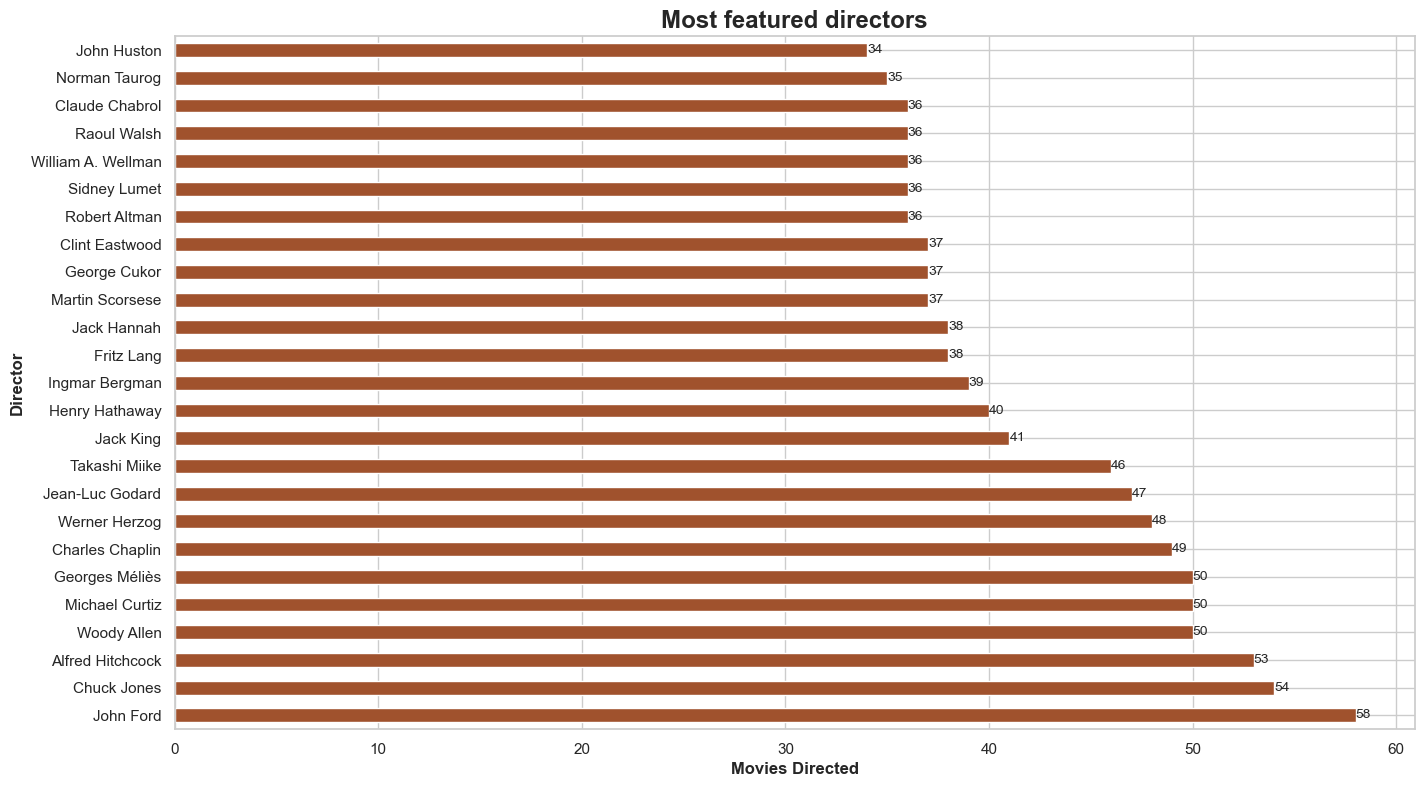

In [199]:
# Plotting most productive directors
graph = df_director_freq.head(25).plot( y="movies_directed", kind='barh',  figsize=(16,9),  legend=False, color="sienna")
graph.set_title("Most featured directors", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Movies Directed", fontweight='bold')
graph.set_ylabel("Director", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

Another important consideration os to investigate the contribution of the average director within the data:

In [200]:
# Obtain descriptive statistics
df_director_freq["movies_directed"].describe()

count    18482.000000
mean         2.430365
std          3.463952
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         58.000000
Name: movies_directed, dtype: float64

We see that the vast majority of directors have only directed 1 or 2 movies present in our data. This means that for the majority of cases, the director will not be an important feature in our recommender systems, since the sample size for each is extremely limited. Let's investigate the distribution of movies directed by directors by means of a density plot:

(0.0, 58.0)

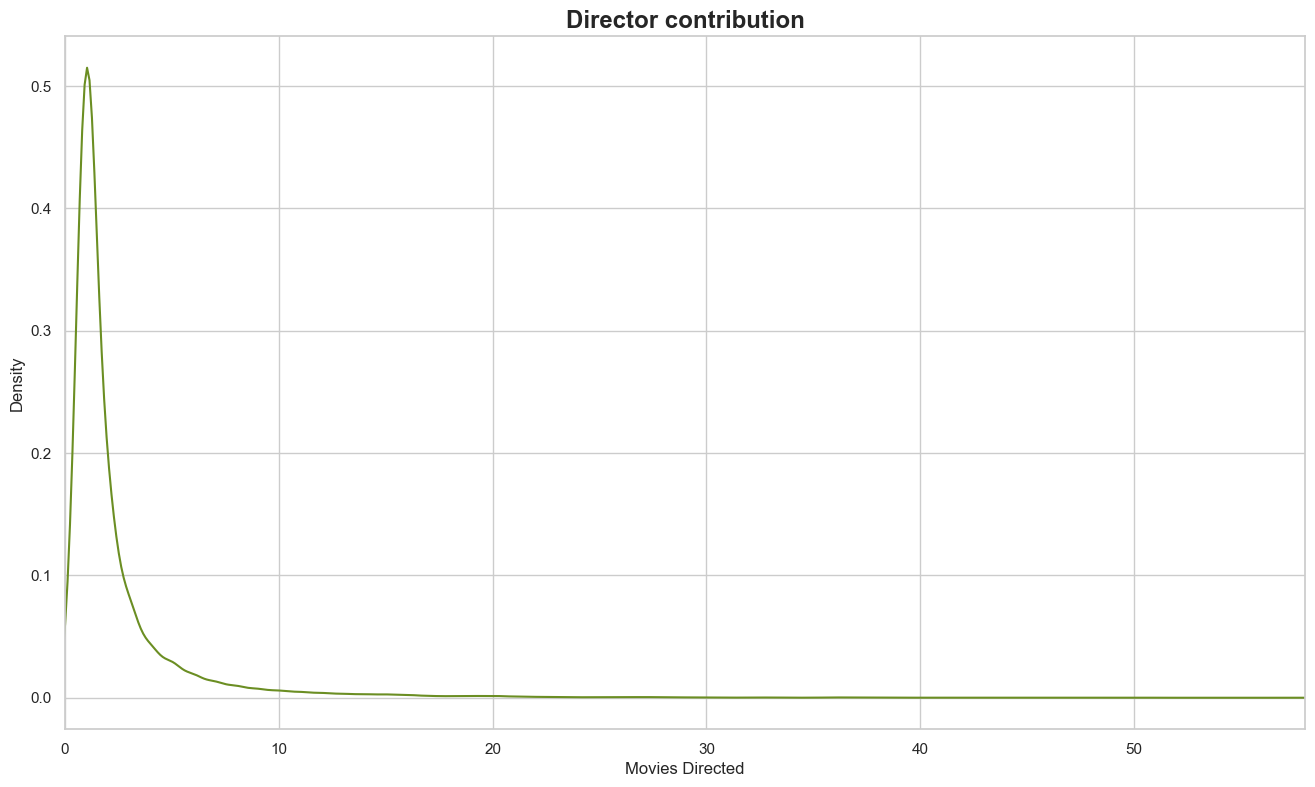

In [201]:
# Plot director contribution distribution
graph = df_director_freq["movies_directed"].plot.density(figsize = (16,9),legend=False, color="olivedrab")
graph.set_title("Director contribution", fontsize="x-large", fontweight='bold')
graph.set_xlabel("Movies Directed")
graph.set_xlim(0, 58)

Yet again, we see the vast majority of directors in the data has only directed 2 or 3 movies at the most. 

Let's consider our best performing directors. In order to ensure statistical relevant ratings, we will only consider directors wha has more that 5000 reviews total:

In [202]:
# Obtaining average ratings and total reviews by grouping by director
df_top_directors = df_director_ratings[["rating", "review_count", "director"]].groupby("director").aggregate({"rating":"mean", "review_count": "sum"})
df_top_directors = df_top_directors[df_top_directors["review_count"]>= 5000]
df_top_directors.sort_values("rating", ascending=False, inplace=True)
df_top_directors.head(25)

rating  review_count
director                                 
Kátia Lund         4.179558        7822.0
Bob Peterson       3.960526       10108.0
Christopher Nolan  3.959255       92106.0
Tony Kaye          3.949778       12554.0
Hayao Miyazaki     3.890891       32051.0
Lee Unkrich        3.850044       19575.0
Jan Pinkava        3.840058        8186.0
Loveleen Tandan    3.821285        7691.0
Ethan Coen         3.804807       49355.0
Quentin Tarantino  3.801142       97479.0
Richard Curtis     3.795643        8081.0
Valerie Faris      3.789024        7902.0
Alex Garland       3.779059        5863.0
Martin McDonagh    3.766269        6949.0
John Lasseter      3.765298       23158.0
Tom Hooper         3.760825        7518.0
Edgar Wright       3.756837       20136.0
Wes Anderson       3.751044       30771.0
Denis Villeneuve   3.750205       11183.0
Nick Park          3.749903       25006.0
Damien Chazelle    3.744156        6601.0
Park Chan-wook     3.734641        7432.0
David Fincher      3.730886       81971.0
Billy Wilder       3.724882       18475.0
Akira Kurosawa     3.722690       15317.0

The table above shows our top performing directors present in the database. We can plot the relative performance of our top 25 directors:

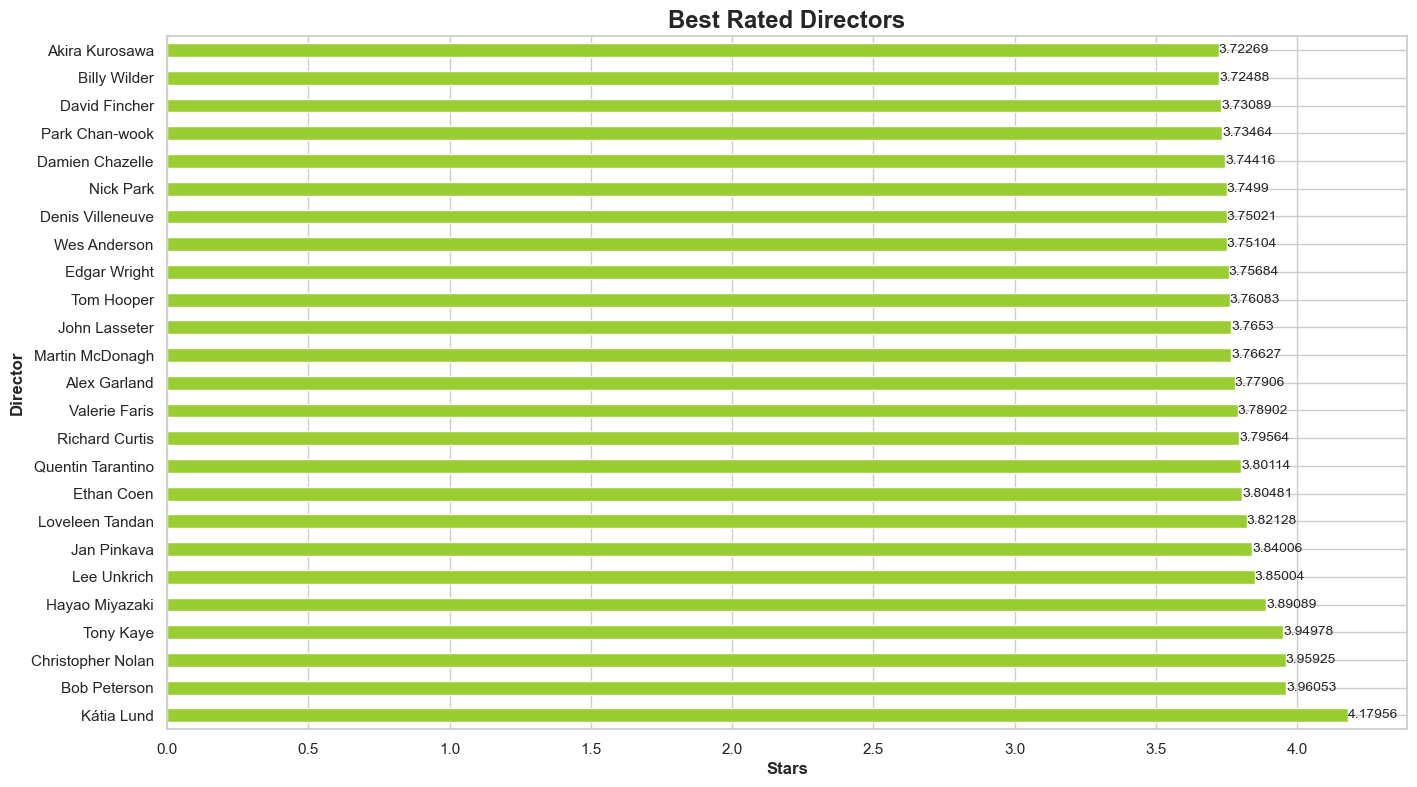

In [203]:
# Plotting best performing directors
graph = df_top_directors.head(25).plot( y="rating", kind='barh',  figsize=(16,9),  legend=False, color="yellowgreen")
graph.set_title("Best Rated Directors", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Stars", fontweight='bold')
graph.set_ylabel("Director", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

We see that the average rating for the top 25 directors falls between 3.7 and 4.2 stars. Recommendations involving the directors listed above should be prioritized, since the average person will rate the works of these directors higher than the average movie. 

Similarly, to show which directors does not receive a lot of love and should be avoided, we look at the worst 25 performing directors:


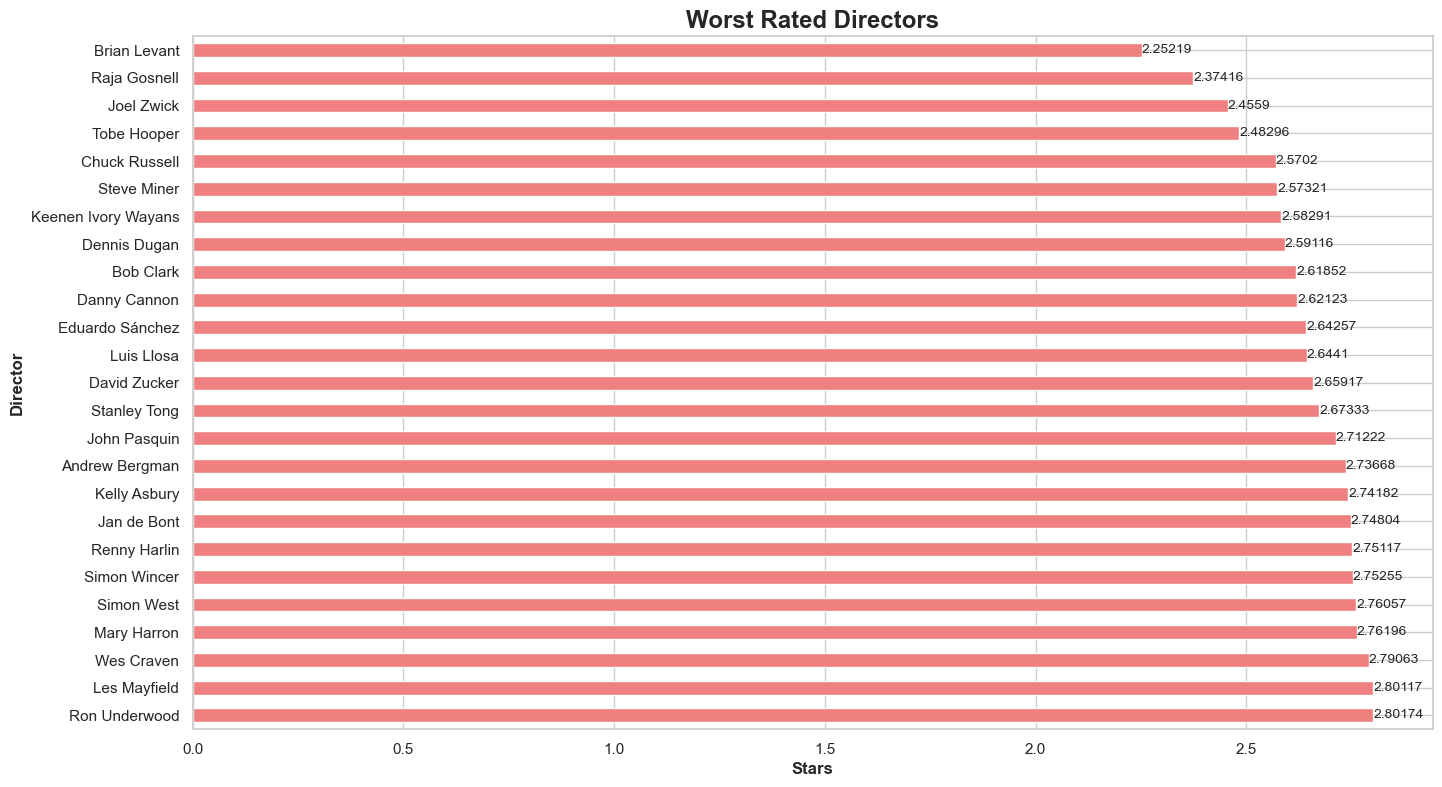

In [204]:
# Plotting worst performing directors
graph = df_top_directors.tail(25).plot( y="rating", kind='barh',  figsize=(16,9),  legend=False, color="lightcoral")
graph.set_title("Worst Rated Directors", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Stars", fontweight='bold')
graph.set_ylabel("Director", fontweight='bold')

for container in graph.containers:
    graph.bar_label(container, fontsize="small")

These directors perform worse than average, and movies produced by them should be carefully considered to be maintained on the streaming site.

#### 3.3.4 Cast Members

We can also consider the cast members starring in the best performing movies, to gain insight into which actors may perform better in ratings compared to others. The first step is to create a list of actors featuring within the dataset. We start by filtering out the cast column from our IMDB data

In [205]:
# Filter out actors from data
df_imdb_actors_eda = imdb_data_df[["movieId", "title_cast"]]

# Making sure our cast is of type string
df_imdb_actors_eda["title_cast"] = df_imdb_actors_eda["title_cast"].astype(str)

df_imdb_actors_eda.head()

movieId                                         title_cast
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...

Next, we apply some text handling to split the actors into single entities:

In [206]:
# Replace spaces with underscores so that actor name and surname stays together
df_imdb_actors_eda["title_cast"] = df_imdb_actors_eda["title_cast"].str.replace(" ", "_")

# Replace pipe character | with a space in order to split the actors into different word entities
df_imdb_actors_eda["title_cast"] = df_imdb_actors_eda["title_cast"].str.replace("|", " ")

# Converting actors in each movie to a list 
df_imdb_actors_eda["title_cast"] = df_imdb_actors_eda["title_cast"].str.split()

df_imdb_actors_eda.head()

movieId                                         title_cast
0        1  [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...
1        2  [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...
2        3  [Walter_Matthau, Jack_Lemmon, Sophia_Loren, An...
3        4  [Whitney_Houston, Angela_Bassett, Loretta_Devi...
4        5  [Steve_Martin, Diane_Keaton, Martin_Short, Kim...

Creating a list that contains all appearances of all actors within our database:

In [207]:
# Create empty list
all_actors = []

# Populate list with all actor appearances in the data
for index, row in df_imdb_actors_eda.iterrows():
    for actor in row["title_cast"]:
        all_actors.append(actor)

print(all_actors[:30])

['Tom_Hanks', 'Tim_Allen', 'Don_Rickles', 'Jim_Varney', 'Wallace_Shawn', 'John_Ratzenberger', 'Annie_Potts', 'John_Morris', 'Erik_von_Detten', 'Laurie_Metcalf', 'R._Lee_Ermey', 'Sarah_Freeman', 'Penn_Jillette', 'Jack_Angel', 'Spencer_Aste', 'Robin_Williams', 'Jonathan_Hyde', 'Kirsten_Dunst', 'Bradley_Pierce', 'Bonnie_Hunt', 'Bebe_Neuwirth', 'David_Alan_Grier', 'Patricia_Clarkson', 'Adam_Hann-Byrd', 'Laura_Bell_Bundy', 'James_Handy', 'Gillian_Barber', 'Brandon_Obray', 'Cyrus_Thiedeke', 'Gary_Joseph_Thorup']


Let's construct a dataframe containing the frequency of all actor appearances in the data:

In [208]:
# Function to count frequency of appearances in list:
def count_actors(actor_list, freq_dict={}):
    """ this function takes in a list of actors and returns a dictionary 
        with each actor as a key, and the value represents the number of 
        times that actor appeared"""
    for actor in actor_list:
        if actor in freq_dict.keys():
            freq_dict[actor] += 1
        else:
            freq_dict[actor] = 1
    return freq_dict

# Create empty dictionary to store actor frequencies
actor_freq = {}

# Applying the function
count_actors(all_actors, actor_freq)

# Removing empty values from consideration
actor_freq.pop('nan')

# Sort dictionary on actor count
actor_freq = sorted(actor_freq.items(), key=lambda x:x[1], reverse=True)

print(actor_freq[0:12])

[('Samuel_L._Jackson', 83), ('Steve_Buscemi', 68), ('Keith_David', 61), ('Willem_Dafoe', 59), ('Robert_De_Niro', 58), ('Christopher_Walken', 57), ('Brian_Cox', 57), ('Gérard_Depardieu', 57), ('Bruce_Willis', 56), ('Morgan_Freeman', 56), ('Danny_Glover', 56), ('Nicolas_Cage', 55)]


Lets investigate the most occurring actors in the dataset: 

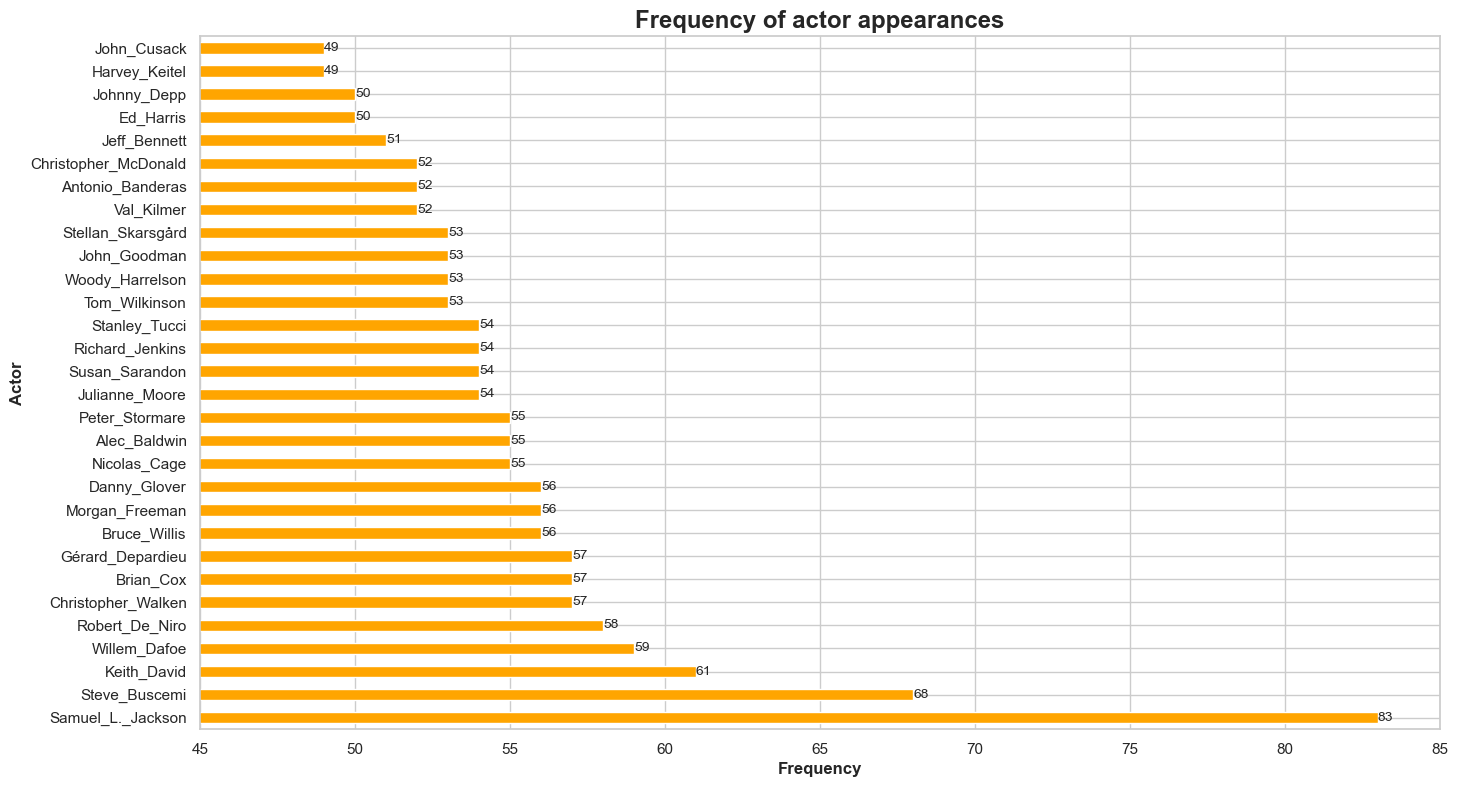

In [209]:
# Create dataframe from dictionary
df_actor_counts = pd.DataFrame(actor_freq, columns=["Actor", "Frequency"])

# Select 30 most occurring actors
df_to_plot = df_actor_counts.head(30)

# Plotting the most occurring actors
graph = df_to_plot.plot(x="Actor", kind='barh',   figsize=(16,9), xlim=[45,85],  legend=False, color = "Orange")
graph.set_title("Frequency of actor appearances", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Frequency", fontweight='bold')
graph.set_ylabel("Actor", fontweight='bold')
for container in graph.containers:
    graph.bar_label(container, fontsize="small")

We see that _Samuel L. Jackson_ is by far the most appearing actor within our dataset, having starred in 83 movies present within our dataset. Among the most featured actors, we also find that most of them appears between 50 and 60 times within the dataset. Also something worth noting is that among the top 30 most occuring actors within our date, only 2 are female, namely __Julianne Moore__ and __Susan Sarandon__

To extend on this, lets dive further into the data and try to arrange our actors not by the amount of movies that they have starred in, but the average rating of all the movies that they have starred in. Doing so, we can identify our highest and lowest performing actors

Let's first consider all the movies we have ratings for, and how many reviews each got:

In [210]:
# Creating a copy of rating data
eda_ratings_df = train_df

# Getting amount of ratings for each movie
movie_rating_counts = pd.DataFrame(eda_ratings_df["movieId"].value_counts())
movie_rating_counts.rename(columns={"count":"review_count"}, inplace=True)

# Creating new feature containing movie rating counts 
eda_ratings_df = pd.merge(eda_ratings_df, movie_rating_counts, on="movieId", how="left")
eda_ratings_df.head()


userId  movieId  rating   timestamp  review_count
0    5163    57669     4.0  1518349992          4253
1  106343        5     4.5  1206238739          4648
2  146790     5459     5.0  1076215539          5730
3  106362    32296     2.0  1423042565           658
4    9041      366     3.0   833375837          1077

We start by averaging our ratings data based on the movie:

In [211]:
# Getting average ratings for movies:
movie_average_ratings_df = eda_ratings_df.groupby(by="movieId").mean()
movie_average_ratings_df.drop(["userId", "timestamp"], axis=1, inplace=True)
movie_average_ratings_df.sort_values(by="review_count", ascending=False).head(10)

rating  review_count
movieId                        
318      4.417624       32831.0
356      4.047216       32383.0
296      4.195097       31697.0
593      4.144172       29444.0
2571     4.154253       29014.0
260      4.111811       27560.0
480      3.684634       25518.0
527      4.247625       24004.0
110      3.994119       23722.0
2959     4.227906       23536.0

To ensure statistically relevant ratings, we disregard all movies with fewer than 300 ratings from consideration when determining best performing actors

In [212]:
# Remove low reviewed movies from consideration
print("Before filtering review count:", len(movie_average_ratings_df)) 
movie_average_ratings_df = movie_average_ratings_df[movie_average_ratings_df["review_count"]>=1000]
print("After filtering review count:", len(movie_average_ratings_df))


Before filtering review count: 48213
After filtering review count: 2118


We see that more than half of the movies contains less than 10 reviews, and were removed from consideration for determining the best performing actors. We can safely join our movie reviews to our actors dataframe:

In [213]:
# Merging average review value to actor data
df_actor_movie_ratings = pd.merge(df_imdb_actors_eda, movie_average_ratings_df, on="movieId",how="inner" )
df_actor_movie_ratings.head()

movieId                                         title_cast    rating  \
0        1  [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...  3.889971   
1        2  [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...  3.263414   
2        3  [Walter_Matthau, Jack_Lemmon, Sophia_Loren, An...  3.132325   
3        5  [Steve_Martin, Diane_Keaton, Martin_Short, Kim...  3.059165   
4        6  [Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Vo...  3.857906   

   review_count  
0       23062.0  
1        9654.0  
2        4727.0  
3        4648.0  
4        9828.0

Now, we obtain the average rating per actor to determine which actors perform the best:

In [214]:
# Function to get average actor ratings
def get_actor_ratings(df_input):
    # Create empty output dataframe
    output_dict = {}

    # Iterate over input dataframe
    for index, row in df_input.iterrows():
        movieId = row['movieId']
        cast = row['title_cast']
        average_rating = row["rating"]
        review_count = row["review_count"]

        # Iterate through actors in cast list
        for actor in cast:

            if actor in output_dict:
                # Actor already exists in the dataframe, update the average rating

                # Obtain stored values in dataframe
                current_rating, current_count = output_dict[actor]

                # Update values based on new data
                new_rating = ((current_rating * current_count) + (average_rating * review_count)) / (current_count + review_count)
                output_dict[actor] = (new_rating, current_count + review_count)
            else:
                # Actor doesn't exist in the dataframe, add a new row
                output_dict[actor] = (average_rating, review_count)
    
    # Convert dictionary to dataframe
    df_output =  pd.DataFrame.from_dict(output_dict, orient='index', columns=['AverageActorRating', 'ActorReviewCount'])
    df_output.index.name = 'Actor'
    df_output.reset_index(inplace=True)
    return df_output

# Applying the function
actor_ratings_df = get_actor_ratings(df_actor_movie_ratings)
actor_ratings_df.head()

Actor  AverageActorRating  ActorReviewCount
0      Tom_Hanks            3.818459          195140.0
1      Tim_Allen            3.744992           51518.0
2    Don_Rickles            3.858756           46795.0
3     Jim_Varney            3.780130           36940.0
4  Wallace_Shawn            3.755523           64544.0

We can also consider the amount of movies each actor has starred in. To improve the statistical significance of our actor rating, we exclude actors who has starred in $10$ movies or less from consideration:

In [215]:
# Merge movie counts into actor reviews
actor_ratings_df = pd.merge(actor_ratings_df, df_actor_counts, on="Actor")
actor_ratings_df.rename(columns={"Frequency":"MovieCount"}, inplace=True)
# Only consider actors with more than 10 movies under their belt
actor_ratings_df = actor_ratings_df[actor_ratings_df["MovieCount"]>10]

actor_ratings_to_plot = actor_ratings_df.sort_values("AverageActorRating", ascending=False).head(30)
actor_ratings_to_plot.head()

Actor  AverageActorRating  ActorReviewCount  MovieCount
2010         Gil_Bellows            4.417624           32831.0          25
2008      William_Sadler            4.251727           39231.0          31
2948     Norbert_Weisser            4.247625           24004.0          13
525   Giancarlo_Esposito            4.198979           26440.0          28
2011        Mark_Rolston            4.198154           49025.0          13

Obtaining a visual representation of the results:

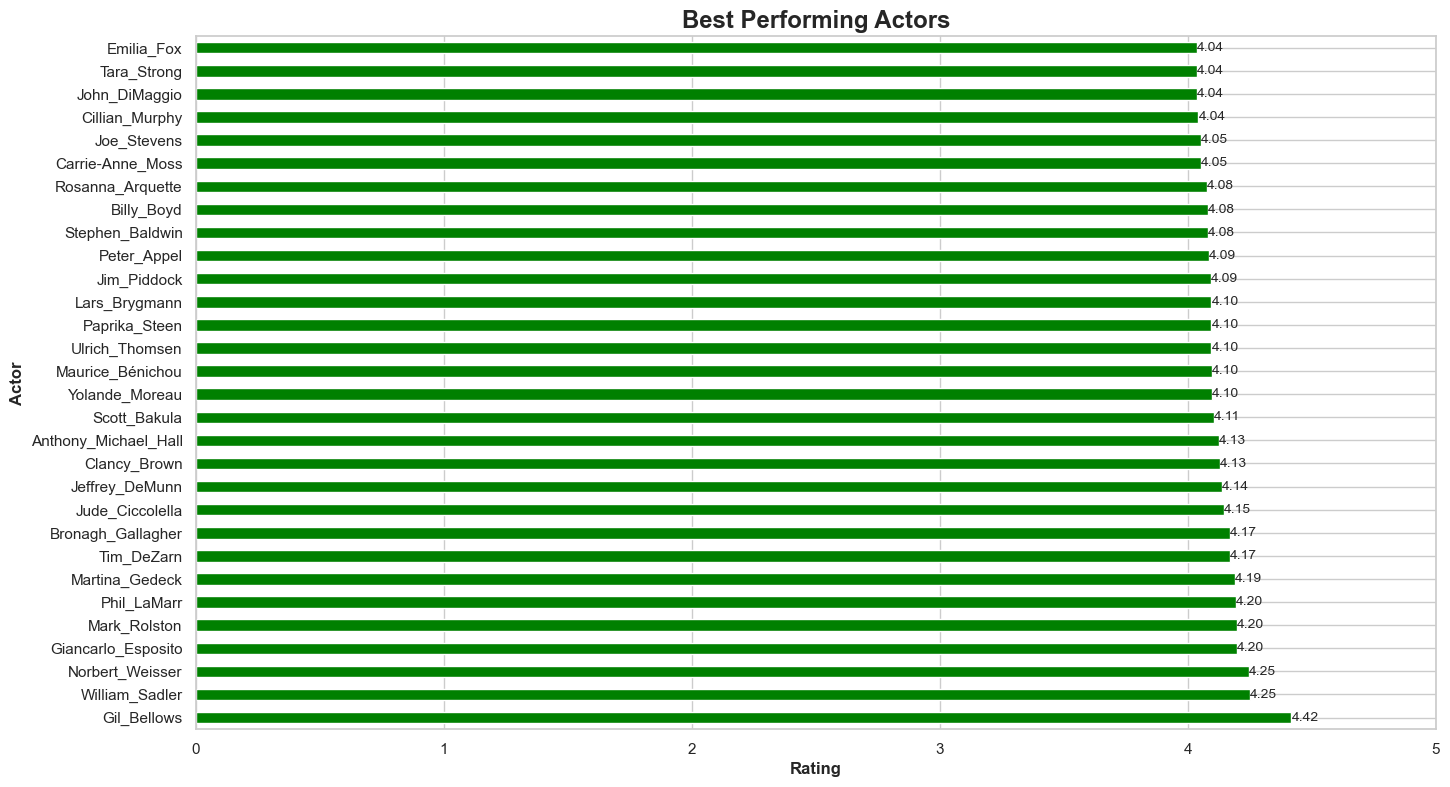

In [216]:
# Plotting the highest rated actors
graph = actor_ratings_to_plot.plot(x="Actor", y="AverageActorRating", kind='barh',   figsize=(16,9), xlim=[0,5],  legend=False, color = "Green")
graph.set_title("Best Performing Actors", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Rating", fontweight='bold')
graph.set_ylabel("Actor", fontweight='bold')
for container in graph.containers:
    graph.bar_label(container, fontsize="small", fmt="%.2f")

Interestingly, our list of best performing actors contain very few *A-List* actors, and mostly obscure and lesser known artists who performs well consistently. This could be due to the fact that they have less reviews under their name than the more well known actors, but since we only included actors with reasonable review data and more than $10$ movies under their belt, this is a surprisingly important discovery, and should be taken into account when recommending movies to the public.

Similarly, we can also investigate the worst performing actors, in order to obtain a list of artists to steer away form recommendations:

In [217]:
# Investigate worst performing actors
actor_ratings_to_plot = actor_ratings_df.sort_values("AverageActorRating", ascending=False).tail(30)
actor_ratings_to_plot.head(30)

Actor  AverageActorRating  ActorReviewCount  MovieCount
139         Lysette_Anthony            2.641017            1475.0          11
10428          Brian_Posehn            2.630363            1515.0          11
4539      Michael_Jai_White            2.623609            2156.0          18
6180           Chris_Kattan            2.599127            1145.0          12
2559          Eddie_Griffin            2.598504            6751.0          21
448     Christopher_Lambert            2.594013            5595.0          19
5962        Natassia_Malthe            2.583445            1492.0          12
5968              Ty_Olsson            2.583445            1492.0          14
5960            David_Lewis            2.583445            1492.0          14
1158         Armand_Assante            2.575672           10605.0          25
10818    Emmanuelle_Chriqui            2.562439            1025.0          23
5585             Burt_Young            2.555709            3258.0          15
1163              Joan_Chen            2.546753            5882.0          18
4663     Freddie_Prinze_Jr.            2.531202            8381.0          17
1243            Robert_Davi            2.530772            5102.0          18
1121    August_Schellenberg            2.517666            4585.0          13
4661   Jennifer_Love_Hewitt            2.517093            5938.0          19
4271          François_Chau            2.507838            2169.0          11
6067            Gary_Grubbs            2.480603            1160.0          13
4812          Marian_Seldes            2.453681            3994.0          11
6569           Roger_Corman            2.450211            2611.0          12
2409      Mario_Van_Peebles            2.435860            1372.0          14
2412     Raoul_Max_Trujillo            2.435860            1372.0          12
11001           Kellan_Lutz            2.399877            2442.0          13
11000            Nikki_Reed            2.399877            2442.0          12
11416      Elizabeth_Reaser            2.326990            1156.0          13
7991    Miguel_A._Núñez_Jr.            2.320913            1248.0          14
1130            Al_Sapienza            2.251748            1287.0          11
4387            Kari_Wuhrer            2.095299            2361.0          14
5304           Carmen_Ejogo            2.029218            1061.0          12

We see much the same effect for poorly performing actors as we did for the best performing actors. Most of these artists are not well known, and we can conclude that they probably star in movies that are more towards the lower end of the budget spectra. Showing this visually:

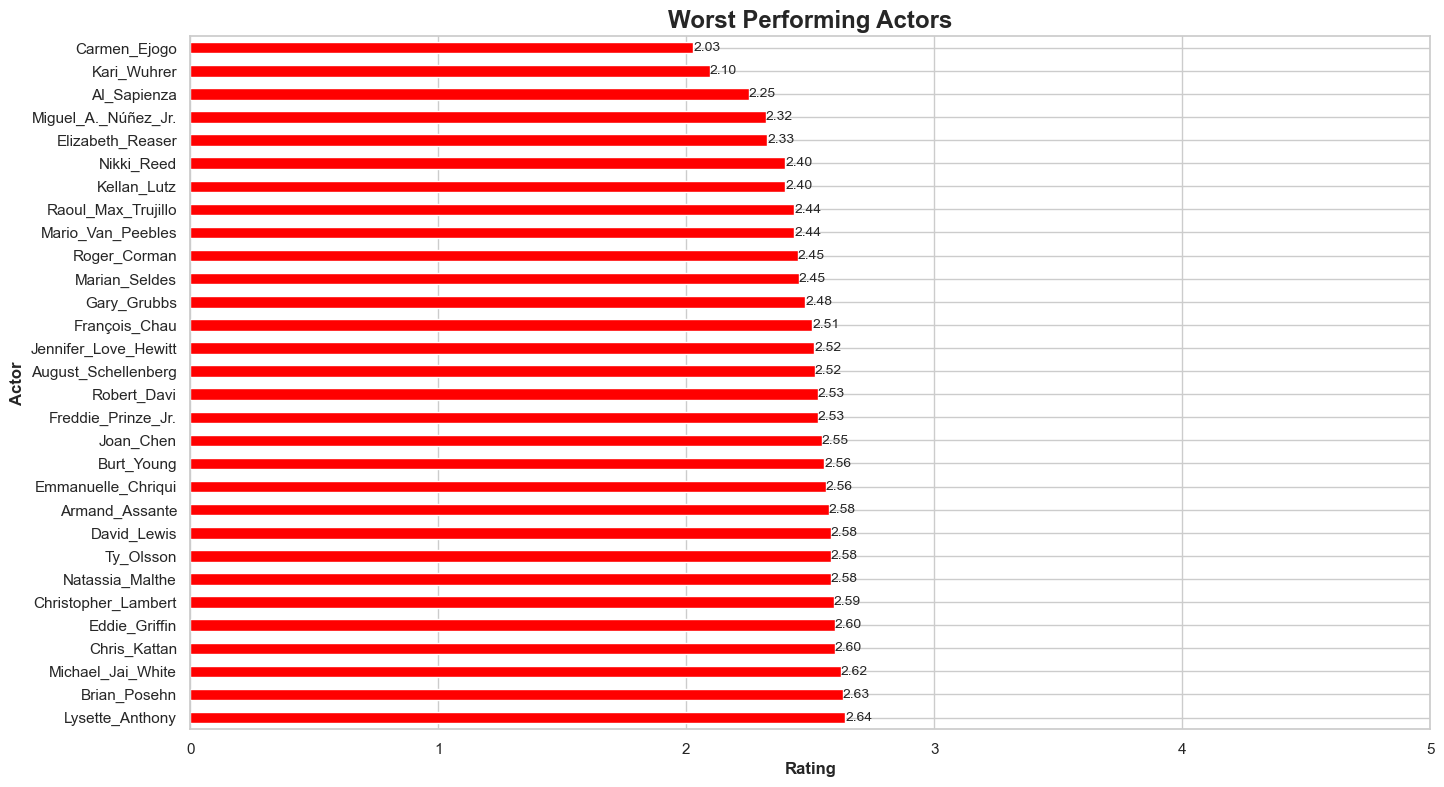

In [218]:
# Plotting the lowest rated actors
graph = actor_ratings_to_plot.plot(x="Actor", y="AverageActorRating", kind='barh',   figsize=(16,9), xlim=[0,5],  legend=False, color = "Red")
graph.set_title("Worst Performing Actors", fontweight='bold', fontsize="x-large")
graph.set_xlabel("Rating", fontweight='bold')
graph.set_ylabel("Actor", fontweight='bold')
for container in graph.containers:
    graph.bar_label(container, fontsize="small", fmt="%.2f")

### 3.4 Correlation between budget and movie rating

To investigate if there exists a correlation between movie budget and the average rating of the movie, we first need to clean the budget data for the movie:

In [219]:
# Create currency converter
c = CurrencyConverter()
available_currencies = list(c.currencies)

# Function to clean movie budget
def clean_and_convert_budget(budgetstring):

        # Test if value is missing
    if budgetstring != budgetstring:
        return np.nan
    
    # Delete commas from input string
    budgetstring = budgetstring.replace(",", "")

    # If in USD, convert to correct int format
    if budgetstring[0] == '$':
        new_budget = budgetstring.replace('$', '')
        return int(new_budget)
    
    # If able to convert to USD, convert to USD
    elif budgetstring[:3] in available_currencies:
        currency = budgetstring[:3]
        value = budgetstring[3:]
        new_value = c.convert(int(value), currency, "USD")
        return int(new_value)

    # If unable to convert to USD, delete entry since we can't use it
    else:
        return np.nan


# Applying the function
df_eda_budget = imdb_data_df[["movieId", 'budget']]
df_eda_budget['budget'] = df_eda_budget["budget"].apply(clean_and_convert_budget)
df_eda_budget.head()
    
    

movieId      budget
0        1  30000000.0
1        2  65000000.0
2        3  25000000.0
3        4  16000000.0
4        5  30000000.0

Next, we can join our average movie ratings to the table above, in order to see of there exist a relationship between movie budget and rating received

In [220]:
# Combining table with rating data
df_eda_budget = pd.merge(df_eda_budget, df_ratings[['rating', 'review_count', 'movieId']], on="movieId", how='left')
df_eda_budget.head()

movieId      budget    rating  review_count
0        1  30000000.0  3.889971       23062.0
1        2  65000000.0  3.263414        9654.0
2        3  25000000.0  3.132325        4727.0
3        4  16000000.0  2.878099         968.0
4        5  30000000.0  3.059165        4648.0

Finally, we can plot the rating against the movie budget to investigate if a correlation exist:

The correlation coefficient between budget and movie rating is  0.016


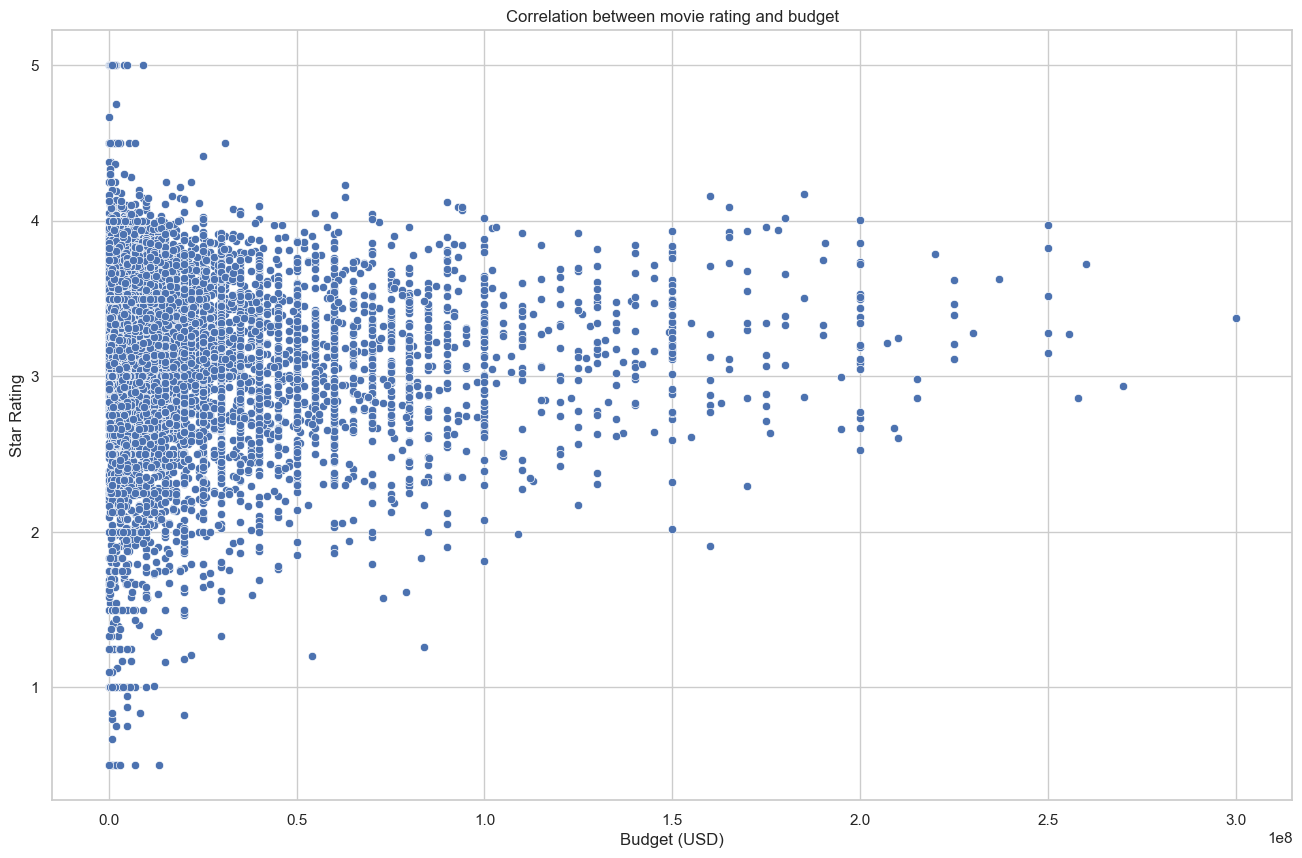

In [221]:
# Plotting scatterplot for correlation
plt.figure(figsize=(16,10))
sns.scatterplot(data=df_eda_budget, x='budget', y='rating')
plt.xlabel("Budget (USD)")
plt.ylabel("Star Rating")
plt.title("Correlation between movie rating and budget")

print('The correlation coefficient between budget and movie rating is ',round(df_eda_budget['budget'].corr(df_eda_budget['rating']),3))

We see that the movie budget is not a strong indicator of the viewer ratings. As such, we will not use the movie budget as a feature in the recommender system

### 3.5 User Tags and Genome Tags

The final piece of the puzzle we have yet to consider involves the tags metadata for each movie. We will start by investigating the user tags present in our data. To see which tags are more common, let's draw a wordcloud of all the tags applied to movies in the dataset

(-0.5, 1599.5, 1599.5, -0.5)

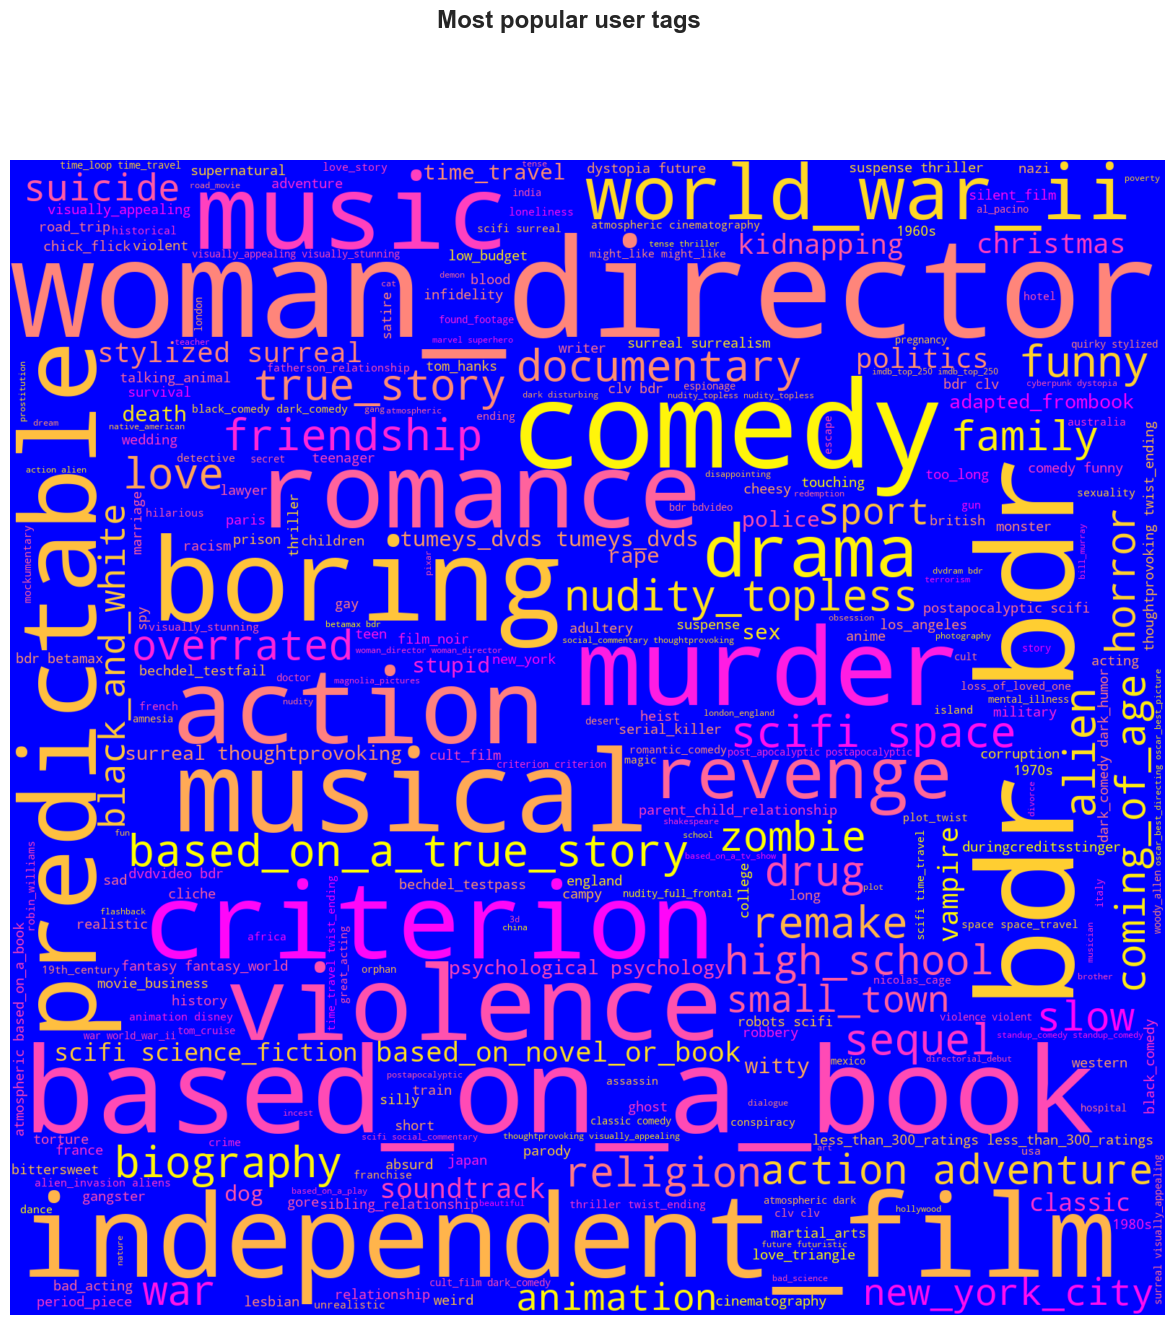

In [222]:
# Create copy of dataframe
eda_tags_df = tags_df
# Making sure each tag is it's own entity
eda_tags_df['tag'] = eda_tags_df['tag'].astype(str)
eda_tags_df['tag'] = eda_tags_df['tag'].str.replace(' ', '_')
eda_tags_df['tag'] = eda_tags_df['tag'].str.lower()

# Removing all punctuation instead of _
removelist = []
for punc in string.punctuation:
    if punc != '_':
        removelist.append(punc)

# Removing all other punctuation
for char in removelist:
    eda_tags_df['tag'] = eda_tags_df['tag'].str.replace(char, '')

# Creating a word string of all tags present
user_tags_wordstring = " ".join(eda_tags_df['tag'])



# Creating wordcloud
plt.figure(figsize=(15,15))
plt.suptitle("Most popular user tags", fontweight='bold', fontsize = "x-large")
wc = WordCloud(background_color="blue", max_words=300, max_font_size= 300,  width=1600, height=1600)
wc.generate(user_tags_wordstring)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')


We find that a few of the tags pertain to the genres of the films (like __action__ or __comedy__) and the viewers opinion of the movie (__predictable__, __boring__, etc ), but for the most part it involves the theme and content found within the movie. For this reason, the user tags will be extremely important in identifying movies with similar plot points and themes when recommending movies.

A similar feature to the user generated tags is the genome tags contained in the `genome_scores.csv` and `genome_tags.csv` files. The only difference here is that there is a set number of tags, and a computer algorithm rates the tag strength for all tags for each movie. If we remove the tags from movies below a certain threshold score, we are left with only strongly correlated tags for each movie, and can therefore treat them the same as our user generated tags above:

In [223]:
# Create copy of dataframe
genome_eda = genome_scores_df

# Filter out low genome scores 
genome_eda = genome_eda[genome_eda["relevance"] >= GENOME_RELEVANCE_THRESHOLD]

# Obtaining relevant tags
genome_eda = pd.merge(genome_eda, genome_tags_df,on='tagId', how='left' )

genome_eda.head()

movieId  tagId  relevance           tag
0        1     19    0.66250        action
1        1     29    0.89375     adventure
2        1     30    0.67625  affectionate
3        1     63    0.94725      animated
4        1     64    0.98425     animation

Using the genome tags we cleaned above, we can investigate what is the most common movie genome tags in our dataset:

(-0.5, 1599.5, 1599.5, -0.5)

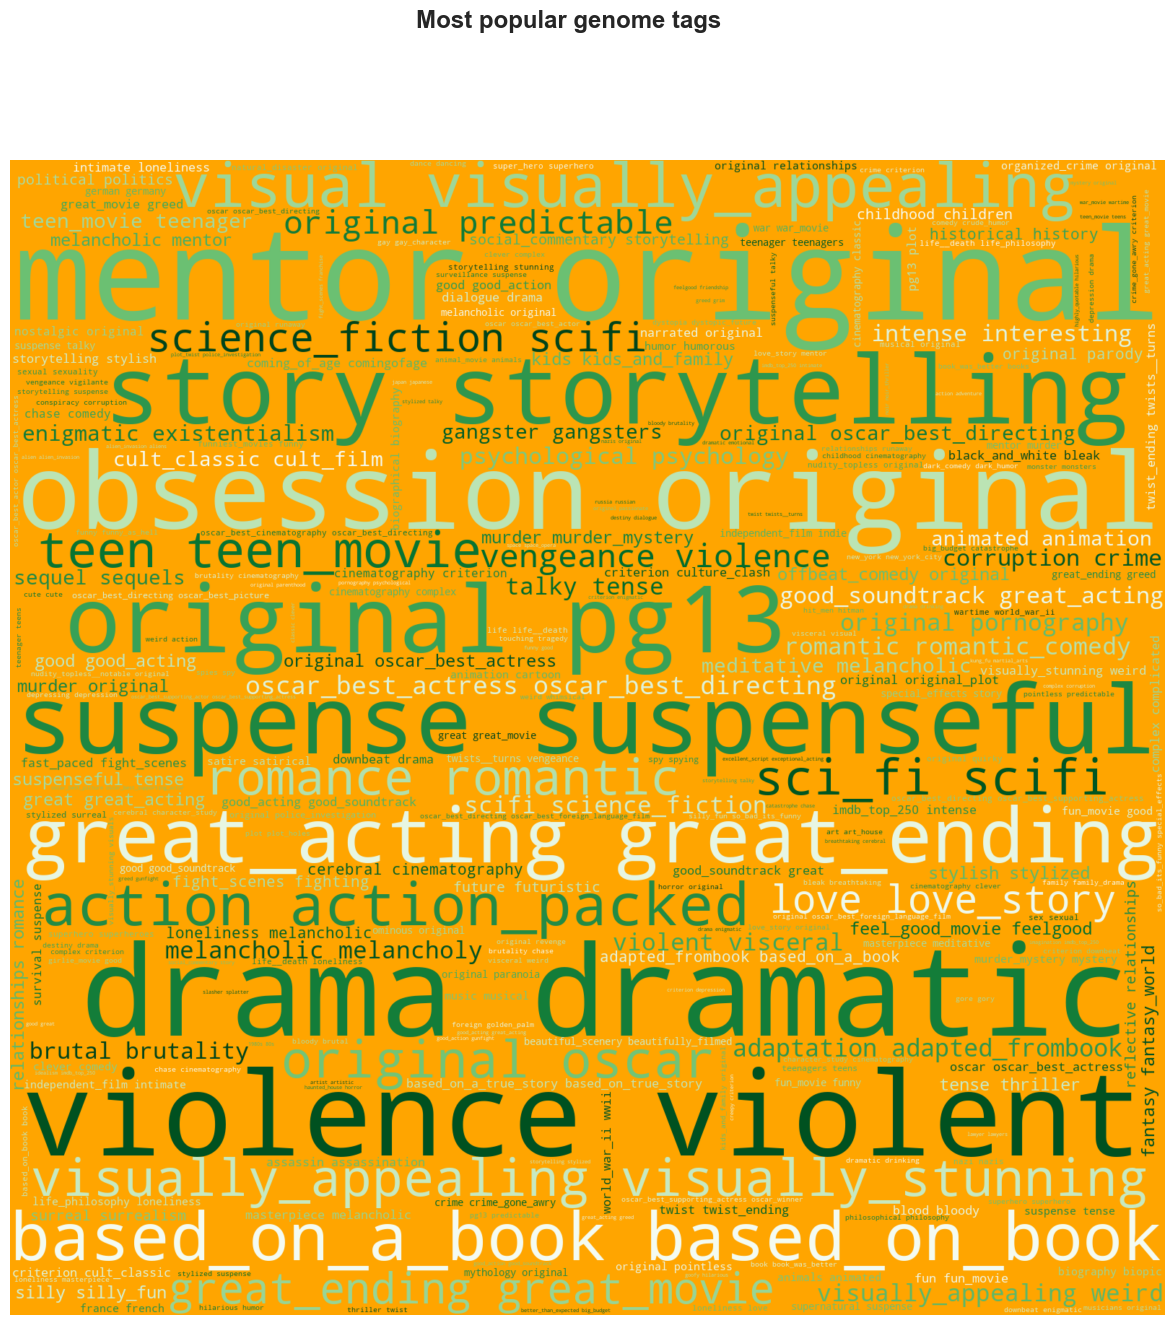

In [224]:
# Making sure each tag is it's own entity
genome_eda['tag'] = genome_eda['tag'].astype(str)
genome_eda['tag'] = genome_eda['tag'].str.replace(' ', '_')
genome_eda['tag'] = genome_eda['tag'].str.lower()

# Removing all punctuation instead of _
removelist = []
for punc in string.punctuation:
    if punc != '_':
        removelist.append(punc)

# Removing all other punctuation
for char in removelist:
    genome_eda['tag'] = genome_eda['tag'].str.replace(char, '')

# Creating a word string of all tags present
genome_tags_wordstring = " ".join(genome_eda['tag'])



# Creating wordcloud
plt.figure(figsize=(15,15))
plt.suptitle("Most popular genome tags", fontweight='bold', fontsize = "x-large")
wc = WordCloud(background_color="orange", max_words=300, max_font_size= 300,  width=1600, height=1600)
wc.generate(genome_tags_wordstring)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

Here, we see that some of our genome tags are very similar to each other (eg __drama__ and __dramatic__). The most occuring genome tags indicates that most  of the movies in our dataset are dramatic, suspenseful, violent and original. We can therefore combine this feature with the user tags discussed above, to create a combined tag feature

<a id="four"></a>
## 4. Data Engineering and NLP Preprocessing
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



To capture all the preprocessing happening within the data, we start a comet experiment:

In [225]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key = COMET_API_KEY,
    project_name = COMET_PROJECT_NAME,
    workspace= COMET_WORKSPACE
  )

  experiment.add_tag("Data Preprocessing")
  experiment.set_name("Data Preprocessing")

We first begin by reloading the data and discarding the changes made during the EDA section:

In [226]:
# Reset all dataframes to original structure to aid with coherent preprocessing
genome_scores_df = pd.read_csv('genome_scores.csv')
genome_tags_df = pd.read_csv('genome_tags.csv')
imdb_data_df = pd.read_csv('imdb_data.csv')
links_df = pd.read_csv('links.csv')
movies_df = pd.read_csv('movies.csv')
tags_df = pd.read_csv('tags.csv')
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

We also reload the supplementary director data that we have downloaded in order to fix the inaccurate director data in our native dataset:

In [227]:
# Resetting supplementary IMDB Data
extra_imdb_name_basics_df = pd.read_table("./Resources/imdb_name_basics.tsv")
extra_imdb_title_crew_df = pd.read_table("./Resources/imdb_title_crew.tsv")

Let's start by updating our faulty director data. 

To make sure we apply the changes correctly, we first view the current data as is:


In [228]:
# Showing current state of data
imdb_data_df.head(10)

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   
5        6  Al Pacino|Robert De Niro|Val Kilmer|Jon Voight...   
6        7  Harrison Ford|Julia Ormond|Greg Kinnear|Nancy ...   
7        8  Jonathan Taylor Thomas|Brad Renfro|Eric Schwei...   
8        9  Jean-Claude Van Damme|Powers Boothe|Raymond J....   
9       10  Pierce Brosnan|Sean Bean|Izabella Scorupco|Fam...   

              director  runtime       budget  \
0        John Lasseter     81.0  $30,000,000   
1   Jonathan Hensleigh    104.0  $65,000,000   
2  Mark Steven Johnson    101.0  $25,000,000   
3       Terry McMillan    124.0  $16,000,000   
4       Albert Hackett    106.0  $30,000,000   
5         Michael Mann    170.0  $60,000,000   
6     Samuel A. Taylor    127.0  $58,000,000   
7           Mark Twain     97.0          NaN   
8  Karen Elise Baldwin    111.0  $35,000,000   
9          Ian Fleming    130.0  $60,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion  
5  gun battle|organized crime|honor|criminal inve...  
6   character name as title|chauffeur|estate|playboy  
7  rescue from drowning|near drowning|character n...  
8     hockey|death in title|two word title|terrorist  
9  official james bond series|james bond characte...

Let's process the new director data so that it fits with our data structure:

In [229]:
# Removing unnecessary columns from imported data
extra_imdb_name_basics_df.drop(["birthYear", "deathYear", "primaryProfession", 'knownForTitles'], axis=1, inplace=True)
extra_imdb_title_crew_df.drop(['writers'], axis=1, inplace=True)
extra_imdb_title_crew_df.rename(columns={"directors": "nconst"}, inplace=True)

# Joining imported datasets
df_extra_imdb_combo = pd.merge(extra_imdb_title_crew_df, extra_imdb_name_basics_df, on="nconst", how="left")
df_extra_imdb_combo.drop("nconst", axis=1, inplace=True)

# Converting IMDB ID to correct format
df_extra_imdb_combo.rename(columns={"tconst":"imdbId"}, inplace=True)
df_extra_imdb_combo['imdbId'] = df_extra_imdb_combo['imdbId'].str.replace('tt','').astype(int)
df_extra_imdb_combo.head()

imdbId           primaryName
0       1  William K.L. Dickson
1       2         Émile Reynaud
2       3         Émile Reynaud
3       4         Émile Reynaud
4       5  William K.L. Dickson

Next, we update our director data, using the `links.csv` file to ensure our movieID's line up with the IMDB dataset movie ID's:

In [230]:
# Adding the corresponding IMDB links to the dataframe we need to update:
imdb_data_df = pd.merge(imdb_data_df, links_df[['movieId', 'imdbId']], on='movieId', how='left')

# Merging the correct director into a new column (primaryName) in the dataframe 
imdb_data_df = pd.merge(imdb_data_df, df_extra_imdb_combo, on='imdbId', how='left')



# Function to update the director with correct value
def replace_director(df):
    for index, row in df.iterrows():
        if pd.notnull(row['primaryName']):
            df.at[index, 'director'] = row['primaryName']
    return df

# Applying the function
imdb_data_df = replace_director(imdb_data_df)

# Dropping redundant columns after merge
imdb_data_df.drop('imdbId', axis=1, inplace=True)
imdb_data_df.drop('primaryName', axis=1, inplace=True)

# Verifying the changes
imdb_data_df.head(10)

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   
5        6  Al Pacino|Robert De Niro|Val Kilmer|Jon Voight...   
6        7  Harrison Ford|Julia Ormond|Greg Kinnear|Nancy ...   
7        8  Jonathan Taylor Thomas|Brad Renfro|Eric Schwei...   
8        9  Jean-Claude Van Damme|Powers Boothe|Raymond J....   
9       10  Pierce Brosnan|Sean Bean|Izabella Scorupco|Fam...   

          director  runtime       budget  \
0    John Lasseter     81.0  $30,000,000   
1     Joe Johnston    104.0  $65,000,000   
2    Howard Deutch    101.0  $25,000,000   
3  Forest Whitaker    124.0  $16,000,000   
4    Charles Shyer    106.0  $30,000,000   
5     Michael Mann    170.0  $60,000,000   
6   Sydney Pollack    127.0  $58,000,000   
7     Peter Hewitt     97.0          NaN   
8      Peter Hyams    111.0  $35,000,000   
9  Martin Campbell    130.0  $60,000,000   

                                       plot_keywords  
0                   toy|rivalry|cowboy|cgi animation  
1                   board game|adventurer|fight|game  
2                         boat|lake|neighbor|rivalry  
3  black american|husband wife relationship|betra...  
4                    fatherhood|doberman|dog|mansion  
5  gun battle|organized crime|honor|criminal inve...  
6   character name as title|chauffeur|estate|playboy  
7  rescue from drowning|near drowning|character n...  
8     hockey|death in title|two word title|terrorist  
9  official james bond series|james bond characte...

Now that we have corrected our faulty director data, we can proceed to transform our data into a useful structure. 

To begin, let's create a new dataframe that will house all our available movie data in one convenient location

In [231]:
# Create a df for storing all available movie data
all_movie_data = imdb_data_df

# Add movie title and genres to the new dataframe
all_movie_data = pd.merge(all_movie_data, movies_df, on='movieId', how='left')

# Remove movies with unknown titles
all_movie_data = all_movie_data[all_movie_data['title'].notna()]

# Verifying the changes
all_movie_data.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

          director  runtime       budget  \
0    John Lasseter     81.0  $30,000,000   
1     Joe Johnston    104.0  $65,000,000   
2    Howard Deutch    101.0  $25,000,000   
3  Forest Whitaker    124.0  $16,000,000   
4    Charles Shyer    106.0  $30,000,000   

                                       plot_keywords  \
0                   toy|rivalry|cowboy|cgi animation   
1                   board game|adventurer|fight|game   
2                         boat|lake|neighbor|rivalry   
3  black american|husband wife relationship|betra...   
4                    fatherhood|doberman|dog|mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

The next step is to add the user tags and genome tags to the movie metadata:

In [232]:
# Filter out genome scores below threshold to ensure only relevant tags gets mapped to movie metadata
filtered_genome_tag_data = genome_scores_df[genome_scores_df['relevance']>= GENOME_RELEVANCE_THRESHOLD]

# Merging genome scores with genome tags
filtered_genome_tag_data = pd.merge(filtered_genome_tag_data, genome_tags_df, on='tagId')

# Dropping redundant columns
filtered_genome_tag_data = filtered_genome_tag_data.drop(["tagId", "relevance"], axis=1)

# To keep tags of multiple words as a single entity, we replace spaces with underscores
filtered_genome_tag_data['tag'] = filtered_genome_tag_data['tag'].str.replace(" ", "_")

# Adding a space after each tag so that tags get merged as individual entities
filtered_genome_tag_data['tag'] = filtered_genome_tag_data['tag'] + " "

# Combining all tags for each movie
filtered_genome_tag_data = filtered_genome_tag_data.groupby(by = 'movieId').sum()

# Renaming tag column so that it does not get confused with user generated tags later on
filtered_genome_tag_data.rename(columns={"tag": "genome_tags"}, inplace=True)

# Adding our genome tags to movie metadata
all_movie_data = pd.merge(all_movie_data, filtered_genome_tag_data, on='movieId', how='left')

# Verifying changes
all_movie_data.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

          director  runtime       budget  \
0    John Lasseter     81.0  $30,000,000   
1     Joe Johnston    104.0  $65,000,000   
2    Howard Deutch    101.0  $25,000,000   
3  Forest Whitaker    124.0  $16,000,000   
4    Charles Shyer    106.0  $30,000,000   

                                       plot_keywords  \
0                   toy|rivalry|cowboy|cgi animation   
1                   board game|adventurer|fight|game   
2                         boat|lake|neighbor|rivalry   
3  black american|husband wife relationship|betra...   
4                    fatherhood|doberman|dog|mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                         genome_tags  
0  action adventure affectionate animated animati...  
1  adventure childhood children entertaining fami...  
2  original comedy good_sequel gunfight sequel se...  
3  chick_flick divorce girlie_movie relationships...  
4  family feel-good original comedy good_sequel s...

We repeat the process above with the user generated tags:

In [233]:
# Select features to join into movie metadata
modified_user_tags = tags_df[['movieId', 'tag']]

# Replace spaces with underscores so that entities remain unique
modified_user_tags['tag'] = modified_user_tags['tag'].str.replace(" ", "_")

# Adding a space after each tag so that tags get merged as individual entities
modified_user_tags['tag'] = modified_user_tags['tag'] + " "

# Combining all tags for each movie
modified_user_tags = modified_user_tags.groupby(by='movieId').sum()

# Renaming tag column to avoid confusion with genome tags
modified_user_tags.rename(columns={"tag": "user_tags"}, inplace=True)

# Converting tags to lowercase to avoid unwanted distinction
modified_user_tags['user_tags'] = modified_user_tags['user_tags'].str.lower()

# Removing any punctuation except underscores
removelist = []
for punc in string.punctuation:
    if punc != '_':
        removelist.append(punc)

for char in removelist:
    modified_user_tags['user_tags'] = modified_user_tags['user_tags'].str.replace(char, '')

# Adding user tags to movie metadata
all_movie_data = pd.merge(all_movie_data, modified_user_tags, on='movieId', how='left')

# Verifying changes
all_movie_data.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

          director  runtime       budget  \
0    John Lasseter     81.0  $30,000,000   
1     Joe Johnston    104.0  $65,000,000   
2    Howard Deutch    101.0  $25,000,000   
3  Forest Whitaker    124.0  $16,000,000   
4    Charles Shyer    106.0  $30,000,000   

                                       plot_keywords  \
0                   toy|rivalry|cowboy|cgi animation   
1                   board game|adventurer|fight|game   
2                         boat|lake|neighbor|rivalry   
3  black american|husband wife relationship|betra...   
4                    fatherhood|doberman|dog|mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                         genome_tags  \
0  action adventure affectionate animated animati...   
1  adventure childhood children entertaining fami...   
2  original comedy good_sequel gunfight sequel se...   
3  chick_flick divorce girlie_movie relationships...   
4  family feel-good original comedy good_sequel s...   

                                           user_tags  
0  owned imdb_top_250 pixar pixar time_travel chi...  
1  robin_williams time_travel fantasy based_on_ch...  
2  funny best_friend duringcreditsstinger fishing...  
3  based_on_novel_or_book chick_flick divorce int...  
4  aging baby confidence contraception daughter g...

Since the era of release of a movie could be an important feature for recommending other movies to users, we extract the decade when the movie was released from the film title and make it it's own feature


In [234]:
# Feature to create `release_year` and `release_decade` feature from movie title
def get_decade(df):


    # Extract date from title
    df['release_year'] = df['title'].str[-6:]

    # Remove brackets from date
    for char in ['(', ')']:
        df['release_year'] = df['release_year'].str.replace(char, '')
    
    # Extract decade of release from release year
    df['release_decade'] = df['release_year'].str[:-1] + "0's"

    # Converting release year to integer
    #df['release_year'] = df['release_year'].astype(int)

    # Run through df to see if year and decade got extracted correctly:
    for index, row in df.iterrows():
        year = row['release_year']
        if year.isnumeric():
            # Convert year to intiger
            df.at[index, 'release_year'] = int(year)
        else:
            # Year extraction failed. Remove year and decade data
            df.at[index, 'release_year'] = np.nan
            df.at[index, 'release_decade'] = np.nan
    return df

# Applying the function
all_movie_data = get_decade(all_movie_data)

#Verifying changes
all_movie_data.head()

movieId                                         title_cast  \
0        1  Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...   
1        2  Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...   
2        3  Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...   
3        4  Whitney Houston|Angela Bassett|Loretta Devine|...   
4        5  Steve Martin|Diane Keaton|Martin Short|Kimberl...   

          director  runtime       budget  \
0    John Lasseter     81.0  $30,000,000   
1     Joe Johnston    104.0  $65,000,000   
2    Howard Deutch    101.0  $25,000,000   
3  Forest Whitaker    124.0  $16,000,000   
4    Charles Shyer    106.0  $30,000,000   

                                       plot_keywords  \
0                   toy|rivalry|cowboy|cgi animation   
1                   board game|adventurer|fight|game   
2                         boat|lake|neighbor|rivalry   
3  black american|husband wife relationship|betra...   
4                    fatherhood|doberman|dog|mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                         genome_tags  \
0  action adventure affectionate animated animati...   
1  adventure childhood children entertaining fami...   
2  original comedy good_sequel gunfight sequel se...   
3  chick_flick divorce girlie_movie relationships...   
4  family feel-good original comedy good_sequel s...   

                                           user_tags release_year  \
0  owned imdb_top_250 pixar pixar time_travel chi...         1995   
1  robin_williams time_travel fantasy based_on_ch...         1995   
2  funny best_friend duringcreditsstinger fishing...         1995   
3  based_on_novel_or_book chick_flick divorce int...         1995   
4  aging baby confidence contraception daughter g...         1995   

  release_decade  
0         1990's  
1         1990's  
2         1990's  
3         1990's  
4         1990's

Next, we shift our focus to the genres feature. Currently, if we do not have data regarding the genre of a movie, the genre feature contains text stating that no genres are listed. This could be problematic, since this will lead our recommender models to identify similarities between movies we don't have data for when in reality there is none. As such, we delete the text indicating missing genres:

In [235]:
# Remove unlisted genre descriptions
all_movie_data['genres'] = all_movie_data['genres'].str.replace( "(no genres listed)" ,"")

Finally, we need to apply some text cleaning on our text features that we haven't touched yet. Splitting entities and removing punctuation will be performed on the `title_cast`, `director`, `plot_keywords`, and `genres` features

In [236]:
# Process text data
def clean_text_features(df):
    # Features to process
    features = ['title_cast', 'director', 'plot_keywords', 'genres']

    # Apply changes to all features
    for feature in features:
        # Replace spaces with underscores to ensure multiple-worded concepts gets treated as single entity
        df[feature] = df[feature].str.replace(' ', '_')

        # Replace pipe symbol (|) with space to separate different entities
        df[feature] = df[feature].str.replace('|', ' ')

        # Convert string to lowercase to avoid unwanted distinctions
        df[feature] = df[feature].str.lower()

    return df

# Applying the function
all_movie_data = clean_text_features(all_movie_data)

# Verifying changes
all_movie_data.head()

movieId                                         title_cast  \
0        1  tom_hanks tim_allen don_rickles jim_varney wal...   
1        2  robin_williams jonathan_hyde kirsten_dunst bra...   
2        3  walter_matthau jack_lemmon sophia_loren ann-ma...   
3        4  whitney_houston angela_bassett loretta_devine ...   
4        5  steve_martin diane_keaton martin_short kimberl...   

          director  runtime       budget  \
0    john_lasseter     81.0  $30,000,000   
1     joe_johnston    104.0  $65,000,000   
2    howard_deutch    101.0  $25,000,000   
3  forest_whitaker    124.0  $16,000,000   
4    charles_shyer    106.0  $30,000,000   

                                       plot_keywords  \
0                   toy rivalry cowboy cgi_animation   
1                   board_game adventurer fight game   
2                         boat lake neighbor rivalry   
3  black_american husband_wife_relationship betra...   
4                    fatherhood doberman dog mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  adventure animation children comedy fantasy   
1                   adventure children fantasy   
2                               comedy romance   
3                         comedy drama romance   
4                                       comedy   

                                         genome_tags  \
0  action adventure affectionate animated animati...   
1  adventure childhood children entertaining fami...   
2  original comedy good_sequel gunfight sequel se...   
3  chick_flick divorce girlie_movie relationships...   
4  family feel-good original comedy good_sequel s...   

                                           user_tags release_year  \
0  owned imdb_top_250 pixar pixar time_travel chi...         1995   
1  robin_williams time_travel fantasy based_on_ch...         1995   
2  funny best_friend duringcreditsstinger fishing...         1995   
3  based_on_novel_or_book chick_flick divorce int...         1995   
4  aging baby confidence contraception daughter g...         1995   

  release_decade  
0         1990's  
1         1990's  
2         1990's  
3         1990's  
4         1990's

The last step involves converting the movie budget to USD, and making sure it is of numeric datatype:

In [237]:
# Create currency converter
c = CurrencyConverter()
available_currencies = list(c.currencies)

# Function to clean movie budget
def clean_and_convert_budget(budgetstring):

    # Test if value is missing
    if budgetstring != budgetstring:
        return np.nan
    
    # Delete commas from input string
    budgetstring = budgetstring.replace(",", "")

    # If in USD, convert to correct int format
    if budgetstring[0] == '$':
        new_budget = budgetstring.replace('$', '')
        return int(new_budget)
    
    # If able to convert to USD, convert to USD
    elif budgetstring[:3] in available_currencies:
        currency = budgetstring[:3]
        value = budgetstring[3:]
        new_value = c.convert(int(value), currency, "USD")
        return int(new_value)

    # If unable to convert to USD, delete entry since we can't use it
    else:
        return np.nan


# Applying the function
all_movie_data['budget'] = all_movie_data["budget"].apply(clean_and_convert_budget)
all_movie_data.head()
    

movieId                                         title_cast  \
0        1  tom_hanks tim_allen don_rickles jim_varney wal...   
1        2  robin_williams jonathan_hyde kirsten_dunst bra...   
2        3  walter_matthau jack_lemmon sophia_loren ann-ma...   
3        4  whitney_houston angela_bassett loretta_devine ...   
4        5  steve_martin diane_keaton martin_short kimberl...   

          director  runtime      budget  \
0    john_lasseter     81.0  30000000.0   
1     joe_johnston    104.0  65000000.0   
2    howard_deutch    101.0  25000000.0   
3  forest_whitaker    124.0  16000000.0   
4    charles_shyer    106.0  30000000.0   

                                       plot_keywords  \
0                   toy rivalry cowboy cgi_animation   
1                   board_game adventurer fight game   
2                         boat lake neighbor rivalry   
3  black_american husband_wife_relationship betra...   
4                    fatherhood doberman dog mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  adventure animation children comedy fantasy   
1                   adventure children fantasy   
2                               comedy romance   
3                         comedy drama romance   
4                                       comedy   

                                         genome_tags  \
0  action adventure affectionate animated animati...   
1  adventure childhood children entertaining fami...   
2  original comedy good_sequel gunfight sequel se...   
3  chick_flick divorce girlie_movie relationships...   
4  family feel-good original comedy good_sequel s...   

                                           user_tags release_year  \
0  owned imdb_top_250 pixar pixar time_travel chi...         1995   
1  robin_williams time_travel fantasy based_on_ch...         1995   
2  funny best_friend duringcreditsstinger fishing...         1995   
3  based_on_novel_or_book chick_flick divorce int...         1995   
4  aging baby confidence contraception daughter g...         1995   

  release_decade  
0         1990's  
1         1990's  
2         1990's  
3         1990's  
4         1990's

That marks the end of data preprocessing for the movie metadata

Let us now divert our focus to filtering our rating data that will be used for model training based on user and movie review thresholds

In [238]:
# Explore the amount of training data before filtering:
before_filter_length = len(train_df)
print('Pre-filtering: training data consists of', before_filter_length, 'entities')

# Function to filter dataframe based on counts of value appearances in specified column:
def filter_by_valuecounts(df, column, threshold):
    result = df[df[column].map(df[column].value_counts()) >= threshold]
    return result

# Applying function to training dataset for movie and user thresholds
train_df_filtered = train_df
train_df_filtered = filter_by_valuecounts(train_df_filtered, 'userId', USER_REVIEW_THRESHOLD)
train_df_filtered = filter_by_valuecounts(train_df_filtered, 'movieId', MOVIE_REVIEW_THRESHOLD)

# Explore the amount of training data after filtering:
after_filter_length = len(train_df_filtered)
print('Post-filtering: training data consists of', after_filter_length, 'entities')
print('Reduction of', before_filter_length - after_filter_length, 'entities: ', after_filter_length/before_filter_length*100, '% of original dataset used')



Pre-filtering: training data consists of 10000038 entities
Post-filtering: training data consists of 3932372 entities
Reduction of 6067666 entities:  39.32357057043183 % of original dataset used


Ending the comet experiment for data preprocessing:

In [239]:
if COMET_FLAG:
    experiment.end()

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



### 5.1 Content based filtering 

__INSERT DESCRIPTION HERE__

To start off, let's remember to start a comet experiment in order to track model version control

In [240]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key = COMET_API_KEY,
    project_name = COMET_PROJECT_NAME,
    workspace= COMET_WORKSPACE
  )

  experiment.add_tag("Content based filter")
  experiment.set_name("Content based filter")

else:
  print("Experiment not logged")

Experiment not logged


Next, we need to determine which features will be included when trying to find similarities between movies. Users might like moves containing certain cast members, and as such, the cast of the movie in question should be taken into account when making recommendations. Similarly, if viewers enjoy the movies produced by certain directors, chances are that they will enjoy the director's other work, and therefore, the movie director should be considered when determining movie similarities. Furthermore, movies that have similar plot keywords will likely have similar plot lines and themes, and therefore this too needs to be considered when determining similarity. Movie genre is another important consideration in similarity, and movies within the same genre should be grouped together. Also, the genome and user tags will be immensely helpful in quantifying similar aspects between movies, and they should also be considered. Finally, users might be in the mood to watch certain movies form the same time period, and therefore we also include the decade of release into our considerations:

In [249]:
# Function to combine movie features 
def combine_content_features(row):
 return row['title_cast'] + ' ' + row['director'] + ' ' + row['plot_keywords']+ ' ' + row['genres'] + ' ' + row['genome_tags'] + ' ' + row['user_tags'] + ' ' + row['release_decade']

# Creating a copy of the data for use in the content based filter
content_filter_data = all_movie_data

# Making sure we convert all text data to string datatype
content_filter_data['title_cast'] = content_filter_data['title_cast'].astype(str)
content_filter_data['director'] = content_filter_data['director'].astype(str)
content_filter_data['plot_keywords'] = content_filter_data['plot_keywords'].astype(str)
content_filter_data['genres'] = content_filter_data['genres'].astype(str)
content_filter_data['genome_tags'] = content_filter_data['genome_tags'].astype(str)
content_filter_data['user_tags'] = content_filter_data['user_tags'].astype(str)
content_filter_data['release_decade'] = content_filter_data['release_decade'].astype(str)


# Applying the function
content_filter_data['combined_features'] = content_filter_data.apply(combine_content_features, axis=1)
content_filter_data.head()

movieId                                         title_cast  \
0        1  tom_hanks tim_allen don_rickles jim_varney wal...   
1        2  robin_williams jonathan_hyde kirsten_dunst bra...   
2        3  walter_matthau jack_lemmon sophia_loren ann-ma...   
3        4  whitney_houston angela_bassett loretta_devine ...   
4        5  steve_martin diane_keaton martin_short kimberl...   

          director  runtime      budget  \
0    john_lasseter     81.0  30000000.0   
1     joe_johnston    104.0  65000000.0   
2    howard_deutch    101.0  25000000.0   
3  forest_whitaker    124.0  16000000.0   
4    charles_shyer    106.0  30000000.0   

                                       plot_keywords  \
0                   toy rivalry cowboy cgi_animation   
1                   board_game adventurer fight game   
2                         boat lake neighbor rivalry   
3  black_american husband_wife_relationship betra...   
4                    fatherhood doberman dog mansion   

                                title  \
0                    Toy Story (1995)   
1                      Jumanji (1995)   
2             Grumpier Old Men (1995)   
3            Waiting to Exhale (1995)   
4  Father of the Bride Part II (1995)   

                                        genres  \
0  adventure animation children comedy fantasy   
1                   adventure children fantasy   
2                               comedy romance   
3                         comedy drama romance   
4                                       comedy   

                                         genome_tags  \
0  action adventure affectionate animated animati...   
1  adventure childhood children entertaining fami...   
2  original comedy good_sequel gunfight sequel se...   
3  chick_flick divorce girlie_movie relationships...   
4  family feel-good original comedy good_sequel s...   

                                           user_tags release_year  \
0  owned imdb_top_250 pixar pixar time_travel chi...         1995   
1  robin_williams time_travel fantasy based_on_ch...         1995   
2  funny best_friend duringcreditsstinger fishing...         1995   
3  based_on_novel_or_book chick_flick divorce int...         1995   
4  aging baby confidence contraception daughter g...         1995   

  release_decade                                  combined_features  
0         1990's  tom_hanks tim_allen don_rickles jim_varney wal...  
1         1990's  robin_williams jonathan_hyde kirsten_dunst bra...  
2         1990's  walter_matthau jack_lemmon sophia_loren ann-ma...  
3         1990's  whitney_houston angela_bassett loretta_devine ...  
4         1990's  steve_martin diane_keaton martin_short kimberl...

Having combined all the features we wish to consider, we can make use of a vectorizer to represent all the text data as numbers for the model to understand:

In [250]:
# Filter out only necessary features
content_filter_data = content_filter_data[['movieId', 'title', 'combined_features']]

# Filter out movies with no combined features

# Create list of titles
content_filter_titles = content_filter_data['title']

# Create list of indexes to map titles to data
content_filter_indices = pd.Series(content_filter_data.index, index=content_filter_data['title'])

# Initializing a vectorizer object
tfidf = TfidfVectorizer(min_df=CONTENT_VEC_MIN_WORD_TO_REMOVE, stop_words=stopwords.words('english')) # Do not consider features occurring less than 10 times in corpus 

# Produce a feature matrix, where each row corresponds to a movie with TF-IDF features as columns
tfidf_combined_features = tfidf.fit_transform(content_filter_data['combined_features'])



(24866, 9169)

We can now compute a cosine similarity matrix in order to gauge the similarity between any two movies in the dataset, based on the vectorized features we supplied: (*Note that this might take a minute or two*)

In [251]:
#Create similarity matrix
content_filter_sim_matrix = cosine_similarity(tfidf_combined_features, tfidf_combined_features)


(24866, 24866)

Now, all that is left to do is to find the closest related movies to a certain movie input:

In [285]:
# Function to recommend movies based on content filtering
def predict_similar_movies(movie_input, number_of_predictions=5):

    # Find all movies containing movie_input as a substring - This is to help with matching movies if complete title is uncertain
    movie_list = [movie for movie in content_filter_titles if str.lower(movie_input) in str.lower(movie)]
    
    # No movies of that title in dataset
    if len(movie_list) == 0:
        return("No movies found. Please check that you have the correct title in mind")
    
    # Multiple movies matching the input
    elif len(movie_list) != 1:
        
        movie_list.insert(0,'''Multiple movies match your input. Please select one of the following:''')
        return movie_list

    else:
        # Obtain the movie index based on the input:
        m_index = content_filter_indices[movie_list[0]]

        # Extract similarity scores computed with reference movie
        sim_scores = list(enumerate(content_filter_sim_matrix[m_index]))

        # Sort the values, keeping a copy of the original index of each value
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Select the top-N values for recommendation
        sim_scores = sim_scores[1:number_of_predictions]

        # Collect indexes 
        movie_indices = [i[0] for i in sim_scores]

        # Convert the indexes back into titles 
        similar_movies = list(content_filter_titles.iloc[movie_indices].values) 

        # Return list of recommended movies
        return('Here is your Recomendations!', similar_movies[:number_of_predictions])



Feel free to test the recommender yourself:

In [288]:
# Movie to use as reference: -CHANGE ME-
your_favourite_movie = "Breakfast Club, The (1985)"

# Amount of recommendations: -CHANGE ME-
amount_to_recommend = 10

# Applying the function
prediction_content_filter = predict_similar_movies(your_favourite_movie, amount_to_recommend)

# Displaying result
prediction_content_filter

('Here is your Recomendations!',
 ['Sixteen Candles (1984)',
  "Ferris Bueller's Day Off (1986)",
  'Pretty in Pink (1986)',
  'The DUFF (2015)',
  'Risky Business (1983)',
  'Kings of Summer, The (2013)',
  'Weird Science (1985)',
  'LOL (2012)',
  'Fast Times at Ridgemont High (1982)'])

Finally, we save all the important parameters used to our comet instance:


In [290]:
# Parameters to save
content_filter_params = {
    'Genome relevance threshold' : GENOME_RELEVANCE_THRESHOLD,
    'Features considered' : ['title_cast',  'director',  'plot_keywords',  'genres',  'genome_tags',  'user_tags',  'release_decade'],
    'Minimum vectorizer df' : CONTENT_VEC_MIN_WORD_TO_REMOVE, 
    'Stop words removed': 'True'
}


if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(content_filter_params)
    # Ending the experiment
    experiment.end()

### 5.2 Collaborative based filtering  

__INSERT DESCRIPTION HERE__

#### 5.2.1 SVD model

__INSERT DESCRIPTION HERE__

To start off, let's remember to start a comet experiment in order to track model version control

In [ ]:
if COMET_FLAG:
  # Start comet experiment:
  experiment = Experiment(
    api_key = COMET_API_KEY,
    project_name = COMET_PROJECT_NAME,
    workspace= COMET_WORKSPACE
  )

  experiment.add_tag("Collaborative based filter")
  experiment.set_name("SVD")

else:
  print("Experiment not logged")

We initialize an SVD model object, asl well as the Reader object which we will use to convert our data into the correct format:

In [293]:
# Initialize Reader:
svd_reader = Reader(rating_scale=(0.5,5)) # Ratings range from 0.5 stars to 5 stars

# Initialize model
svd_model = SVD()

We proceed to convert our data to the correct format for the model:

In [297]:
# The columns must correspond to user id, item id and ratings (in that order). See "Surprise" documentation
svd_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], svd_reader)

We split our data into training and testing subsets:

In [300]:
# Splitting the data
train, test = train_test_split(svd_data, test_size=COLAB_TRAIN_TEST_SPLIT_VAR, random_state=RAND_STATE)

We can then fit the model to the training subset:

In [301]:
# Fitting the model
svd_model.fit(train)

Proceeding to obtain predictions form the model for the testing subset:

In [303]:
# Obtaining predictions
svd_predictions = svd_model.test(test)

We can inspect our model performance by measuring the RMSE of our predictions:

In [305]:
svd_rmse = accuracy.rmse(svd_predictions)

RMSE: 0.9004


We see that our model predicts fairly well, obtaining an RMSE accuracy of $\approx 0.9$ without any hyperparameter tuning

Remembering to end our comet experiment and logging the important details:

In [307]:
# Parameters to save
svd_params = {
    'User review threshold' :USER_REVIEW_THRESHOLD,
    'Movie review threshold':MOVIE_REVIEW_THRESHOLD,
    'Random state': RAND_STATE,
    "Trained on percentage" : 1-COLAB_TRAIN_TEST_SPLIT_VAR, 
    

}

svd_metrics = {
    'RMSE' : svd_rmse
}


if COMET_FLAG:
    # Log all important info
    experiment.log_parameters(svd_params)
    experiment.log_metric(svd_metrics)
    # Ending the experiment
    experiment.end()

#### 5.2.2 SVD - PP model

__INSERT DESCRIPTION HERE__

#### 5.2.3 NMF

__INSERT DESCRIPTION HERE__

#### 5.2.4 Slope one model

__INSERT DESCRIPTION HERE__

#### 5.2.5 Co Clustering

__INSERT DESCRIPTION HERE__

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

To evaluate our model performance, we will make use of the `f1-score` as a metric...


<a id="seven"></a>
## 7. Model selection and tuning
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



---

<a id="eight"></a>
## 8. Conclusions
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



---

In conclusion, our best performing model for predicting sentiment...

#### Future Considerations:


